In [ ]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import dotenv

2024-11-17 22:38:29.788469: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128 
IMAGE_SIZE = 224  # Increased image size to improve feature extraction

### Import Dataset

In [3]:
training_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Training')

class_labels = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
image_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels_reverse = {v: k for k, v in class_labels.items()}

In [ ]:
# Initialize lists to store images and labels for the training dataset
images = []
labels = []

# Loop over the folders in the Training dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(training_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 for ResNet50

        # Append image and label (use list append method)
        images.append(img)
        labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
images = np.array(images)
labels = np.array(labels)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
X_rgb = np.repeat(images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Split the dataset into training and validation sets (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_rgb, labels, test_size=0.2, random_state=42)

# Data augmentation to improve model generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Unfreeze the base model layers to allow fine-tuning
base_model.trainable = True

In [5]:
# Add custom classifier layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Increased the number of neurons
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            


 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             


 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           


 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          


 on)                                                                                              


 conv1_relu (Activation)     (None, 112, 112, 64)         0         ['conv1_bn[0][0]']            


 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_relu[0][0]']          


 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)           0         ['pool1_pad[0][0]']           


 conv2_block1_1_conv (Conv2  (None, 56, 56, 64)           4160      ['pool1_pool[0][0]']          


 D)                                                                                               


 conv2_block1_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block1_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_0_conv (Conv2  (None, 56, 56, 256)          16640     ['pool1_pool[0][0]']          


 D)                                                                                               


 conv2_block1_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block1_0_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_add (Add)      (None, 56, 56, 256)          0         ['conv2_block1_0_bn[0][0]',   


                                                                     'conv2_block1_3_bn[0][0]']   


 conv2_block1_out (Activati  (None, 56, 56, 256)          0         ['conv2_block1_add[0][0]']    


 on)                                                                                              


 conv2_block2_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block1_out[0][0]']    


 D)                                                                                               


 conv2_block2_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block2_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block2_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_add (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    


                                                                     'conv2_block2_3_bn[0][0]']   


 conv2_block2_out (Activati  (None, 56, 56, 256)          0         ['conv2_block2_add[0][0]']    


 on)                                                                                              


 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    


 D)                                                                                               


 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block3_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block3_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block3_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block3_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_add (Add)      (None, 56, 56, 256)          0         ['conv2_block2_out[0][0]',    


                                                                     'conv2_block3_3_bn[0][0]']   


 conv2_block3_out (Activati  (None, 56, 56, 256)          0         ['conv2_block3_add[0][0]']    


 on)                                                                                              


 conv3_block1_1_conv (Conv2  (None, 28, 28, 128)          32896     ['conv2_block3_out[0][0]']    


 D)                                                                                               


 conv3_block1_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block1_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_0_conv (Conv2  (None, 28, 28, 512)          131584    ['conv2_block3_out[0][0]']    


 D)                                                                                               


 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block1_0_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_bn[0][0]',   


                                                                     'conv3_block1_3_bn[0][0]']   


 conv3_block1_out (Activati  (None, 28, 28, 512)          0         ['conv3_block1_add[0][0]']    


 on)                                                                                              


 conv3_block2_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block1_out[0][0]']    


 D)                                                                                               


 conv3_block2_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    


                                                                     'conv3_block2_3_bn[0][0]']   


 conv3_block2_out (Activati  (None, 28, 28, 512)          0         ['conv3_block2_add[0][0]']    


 on)                                                                                              


 conv3_block3_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block2_out[0][0]']    


 D)                                                                                               


 conv3_block3_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block3_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block3_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_add (Add)      (None, 28, 28, 512)          0         ['conv3_block2_out[0][0]',    


                                                                     'conv3_block3_3_bn[0][0]']   


 conv3_block3_out (Activati  (None, 28, 28, 512)          0         ['conv3_block3_add[0][0]']    


 on)                                                                                              


 conv3_block4_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block3_out[0][0]']    


 D)                                                                                               


 conv3_block4_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block4_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block4_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block4_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block4_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block4_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block4_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_add (Add)      (None, 28, 28, 512)          0         ['conv3_block3_out[0][0]',    


                                                                     'conv3_block4_3_bn[0][0]']   


 conv3_block4_out (Activati  (None, 28, 28, 512)          0         ['conv3_block4_add[0][0]']    


 on)                                                                                              


 conv4_block1_1_conv (Conv2  (None, 14, 14, 256)          131328    ['conv3_block4_out[0][0]']    


 D)                                                                                               


 conv4_block1_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    


 D)                                                                                               


 conv4_block1_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block1_0_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_0_bn[0][0]',   


                                                                     'conv4_block1_3_bn[0][0]']   


 conv4_block1_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block1_add[0][0]']    


 on)                                                                                              


 conv4_block2_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block1_out[0][0]']    


 D)                                                                                               


 conv4_block2_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block2_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block2_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_out[0][0]',    


                                                                     'conv4_block2_3_bn[0][0]']   


 conv4_block2_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block2_add[0][0]']    


 on)                                                                                              


 conv4_block3_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block2_out[0][0]']    


 D)                                                                                               


 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block3_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block3_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block2_out[0][0]',    


                                                                     'conv4_block3_3_bn[0][0]']   


 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    


 on)                                                                                              


 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    


 D)                                                                                               


 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block4_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block4_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block4_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block4_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block3_out[0][0]',    


                                                                     'conv4_block4_3_bn[0][0]']   


 conv4_block4_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block4_add[0][0]']    


 on)                                                                                              


 conv4_block5_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block4_out[0][0]']    


 D)                                                                                               


 conv4_block5_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block5_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block5_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block5_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block5_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    


                                                                     'conv4_block5_3_bn[0][0]']   


 conv4_block5_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block5_add[0][0]']    


 on)                                                                                              


 conv4_block6_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block5_out[0][0]']    


 D)                                                                                               


 conv4_block6_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block6_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block6_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block6_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block6_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block6_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    


                                                                     'conv4_block6_3_bn[0][0]']   


 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    


 on)                                                                                              


 conv5_block1_1_conv (Conv2  (None, 7, 7, 512)            524800    ['conv4_block6_out[0][0]']    


 D)                                                                                               


 conv5_block1_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block1_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_0_conv (Conv2  (None, 7, 7, 2048)           2099200   ['conv4_block6_out[0][0]']    


 D)                                                                                               


 conv5_block1_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block1_0_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_0_bn[0][0]',   


                                                                     'conv5_block1_3_bn[0][0]']   


 conv5_block1_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block1_add[0][0]']    


 on)                                                                                              


 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1049088   ['conv5_block1_out[0][0]']    


 D)                                                                                               


 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block2_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block2_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_out[0][0]',    


                                                                     'conv5_block2_3_bn[0][0]']   


 conv5_block2_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block2_add[0][0]']    


 on)                                                                                              


 conv5_block3_1_conv (Conv2  (None, 7, 7, 512)            1049088   ['conv5_block2_out[0][0]']    


 D)                                                                                               


 conv5_block3_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block3_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block2_out[0][0]',    


                                                                     'conv5_block3_3_bn[0][0]']   


 conv5_block3_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block3_add[0][0]']    


 on)                                                                                              


 flatten (Flatten)           (None, 100352)               0         ['conv5_block3_out[0][0]']    


 dense (Dense)               (None, 1024)                 1027614   ['flatten[0][0]']             


                                                          72                                      


 dropout (Dropout)           (None, 1024)                 0         ['dense[0][0]']               


 dense_1 (Dense)             (None, 512)                  524800    ['dropout[0][0]']             


 dropout_1 (Dropout)         (None, 512)                  0         ['dense_1[0][0]']             


 dense_2 (Dense)             (None, 4)                    2052      ['dropout_1[0][0]']           


Total params: 126876036 (483.99 MB)


Trainable params: 126822916 (483.79 MB)


Non-trainable params: 53120 (207.50 KB)


__________________________________________________________________________________________________


In [6]:
# Train the model using the training data
datagen.fit(X_train)
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // BATCH_SIZE)

Epoch 1/50


I0000 00:00:1731901135.852549   37876 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



 1/35 [..............................] - ETA: 9:21 - loss: 4.6584 - accuracy: 0.3047


 2/35 [>.............................] - ETA: 35s - loss: 5.4962 - accuracy: 0.2852 


 3/35 [=>............................] - ETA: 36s - loss: 5.2088 - accuracy: 0.2604


 4/35 [==>...........................] - ETA: 34s - loss: 4.5673 - accuracy: 0.3184


 5/35 [===>..........................] - ETA: 34s - loss: 4.2240 - accuracy: 0.3422


 6/35 [====>.........................] - ETA: 46s - loss: 3.9490 - accuracy: 0.3750


 7/35 [=====>........................] - ETA: 42s - loss: 3.7131 - accuracy: 0.4007


 8/35 [=====>........................] - ETA: 39s - loss: 3.4299 - accuracy: 0.4346


 9/35 [======>.......................] - ETA: 36s - loss: 3.2423 - accuracy: 0.4523


10/35 [=======>......................] - ETA: 33s - loss: 3.1373 - accuracy: 0.4666


11/35 [========>.....................] - ETA: 32s - loss: 3.0185 - accuracy: 0.4763


12/35 [=========>....................] - ETA: 30s - loss: 2.9268 - accuracy: 0.4883


13/35 [==========>...................] - ETA: 28s - loss: 2.8055 - accuracy: 0.5015


14/35 [===========>..................] - ETA: 26s - loss: 2.6966 - accuracy: 0.5163


15/35 [===========>..................] - ETA: 25s - loss: 2.5920 - accuracy: 0.5300


16/35 [============>.................] - ETA: 23s - loss: 2.5106 - accuracy: 0.5411


17/35 [=============>................] - ETA: 22s - loss: 2.4250 - accuracy: 0.5545


18/35 [==============>...............] - ETA: 20s - loss: 2.3696 - accuracy: 0.5625


19/35 [===============>..............] - ETA: 19s - loss: 2.2987 - accuracy: 0.5729


20/35 [================>.............] - ETA: 18s - loss: 2.2412 - accuracy: 0.5803


21/35 [=================>............] - ETA: 16s - loss: 2.1802 - accuracy: 0.5893


22/35 [=================>............] - ETA: 15s - loss: 2.1722 - accuracy: 0.5938


23/35 [==================>...........] - ETA: 14s - loss: 2.1153 - accuracy: 0.6038


24/35 [===================>..........] - ETA: 13s - loss: 2.0509 - accuracy: 0.6136


25/35 [====================>.........] - ETA: 11s - loss: 1.9983 - accuracy: 0.6220


26/35 [=====================>........] - ETA: 10s - loss: 1.9509 - accuracy: 0.6285


27/35 [======================>.......] - ETA: 9s - loss: 1.9099 - accuracy: 0.6348 


28/35 [=======================>......] - ETA: 8s - loss: 1.8677 - accuracy: 0.6420


29/35 [=======================>......] - ETA: 7s - loss: 1.8211 - accuracy: 0.6488


30/35 [========================>.....] - ETA: 5s - loss: 1.7905 - accuracy: 0.6525


31/35 [=========================>....] - ETA: 4s - loss: 1.7585 - accuracy: 0.6582


32/35 [==========================>...] - ETA: 3s - loss: 1.7268 - accuracy: 0.6623


33/35 [===========================>..] - ETA: 2s - loss: 1.6970 - accuracy: 0.6686


34/35 [============================>.] - ETA: 1s - loss: 1.6666 - accuracy: 0.6742


35/35 [==============================] - ETA: 0s - loss: 1.6409 - accuracy: 0.6787


35/35 [==============================] - 64s 1s/step - loss: 1.6409 - accuracy: 0.6787 - val_loss: 2.1451 - val_accuracy: 0.2695


Epoch 2/50



 1/35 [..............................] - ETA: 55s - loss: 0.5825 - accuracy: 0.8672


 2/35 [>.............................] - ETA: 34s - loss: 0.5575 - accuracy: 0.8516


 3/35 [=>............................] - ETA: 34s - loss: 0.4854 - accuracy: 0.8594


 4/35 [==>...........................] - ETA: 33s - loss: 0.4299 - accuracy: 0.8672


 5/35 [===>..........................] - ETA: 32s - loss: 0.4091 - accuracy: 0.8687


 6/35 [====>.........................] - ETA: 31s - loss: 0.4214 - accuracy: 0.8698


 7/35 [=====>........................] - ETA: 30s - loss: 0.4270 - accuracy: 0.8661


 8/35 [=====>........................] - ETA: 29s - loss: 0.4169 - accuracy: 0.8662


 9/35 [======>.......................] - ETA: 28s - loss: 0.4157 - accuracy: 0.8672


10/35 [=======>......................] - ETA: 26s - loss: 0.4407 - accuracy: 0.8648


11/35 [========>.....................] - ETA: 25s - loss: 0.4323 - accuracy: 0.8658


12/35 [=========>....................] - ETA: 24s - loss: 0.4258 - accuracy: 0.8659


13/35 [==========>...................] - ETA: 23s - loss: 0.4224 - accuracy: 0.8684


14/35 [===========>..................] - ETA: 22s - loss: 0.4182 - accuracy: 0.8672


15/35 [===========>..................] - ETA: 21s - loss: 0.4101 - accuracy: 0.8687


16/35 [============>.................] - ETA: 20s - loss: 0.4154 - accuracy: 0.8672


17/35 [=============>................] - ETA: 19s - loss: 0.4084 - accuracy: 0.8695


18/35 [==============>...............] - ETA: 18s - loss: 0.4126 - accuracy: 0.8685


19/35 [===============>..............] - ETA: 17s - loss: 0.4119 - accuracy: 0.8676


20/35 [================>.............] - ETA: 16s - loss: 0.4065 - accuracy: 0.8684


21/35 [=================>............] - ETA: 15s - loss: 0.4077 - accuracy: 0.8698


22/35 [=================>............] - ETA: 14s - loss: 0.4039 - accuracy: 0.8700


23/35 [==================>...........] - ETA: 13s - loss: 0.4057 - accuracy: 0.8699


24/35 [===================>..........] - ETA: 13s - loss: 0.4028 - accuracy: 0.8717


25/35 [====================>.........] - ETA: 12s - loss: 0.3985 - accuracy: 0.8725


26/35 [=====================>........] - ETA: 10s - loss: 0.3899 - accuracy: 0.8738


27/35 [======================>.......] - ETA: 9s - loss: 0.3894 - accuracy: 0.8733 


28/35 [=======================>......] - ETA: 8s - loss: 0.3903 - accuracy: 0.8733


29/35 [=======================>......] - ETA: 7s - loss: 0.3893 - accuracy: 0.8742


30/35 [========================>.....] - ETA: 5s - loss: 0.3886 - accuracy: 0.8748


31/35 [=========================>....] - ETA: 4s - loss: 0.3879 - accuracy: 0.8753


32/35 [==========================>...] - ETA: 3s - loss: 0.3815 - accuracy: 0.8770


33/35 [===========================>..] - ETA: 2s - loss: 0.3806 - accuracy: 0.8774


34/35 [============================>.] - ETA: 1s - loss: 0.3775 - accuracy: 0.8780


35/35 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8784


35/35 [==============================] - 45s 1s/step - loss: 0.3783 - accuracy: 0.8784 - val_loss: 2.4644 - val_accuracy: 0.2371


Epoch 3/50



 1/35 [..............................] - ETA: 55s - loss: 0.2855 - accuracy: 0.8828


 2/35 [>.............................] - ETA: 24s - loss: 0.2451 - accuracy: 0.8986


 3/35 [=>............................] - ETA: 28s - loss: 0.2490 - accuracy: 0.8899


 4/35 [==>...........................] - ETA: 30s - loss: 0.2847 - accuracy: 0.8879


 5/35 [===>..........................] - ETA: 29s - loss: 0.2787 - accuracy: 0.8885


 6/35 [====>.........................] - ETA: 29s - loss: 0.2690 - accuracy: 0.8930


 7/35 [=====>........................] - ETA: 29s - loss: 0.2521 - accuracy: 0.8973


 8/35 [=====>........................] - ETA: 28s - loss: 0.2413 - accuracy: 0.9036


 9/35 [======>.......................] - ETA: 27s - loss: 0.2445 - accuracy: 0.9048


10/35 [=======>......................] - ETA: 26s - loss: 0.2484 - accuracy: 0.9065


11/35 [========>.....................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9058


12/35 [=========>....................] - ETA: 25s - loss: 0.2512 - accuracy: 0.9065


13/35 [==========>...................] - ETA: 23s - loss: 0.2419 - accuracy: 0.9095


14/35 [===========>..................] - ETA: 23s - loss: 0.2371 - accuracy: 0.9122


15/35 [===========>..................] - ETA: 25s - loss: 0.2450 - accuracy: 0.9112


16/35 [============>.................] - ETA: 24s - loss: 0.2435 - accuracy: 0.9114


17/35 [=============>................] - ETA: 22s - loss: 0.2398 - accuracy: 0.9130


18/35 [==============>...............] - ETA: 21s - loss: 0.2391 - accuracy: 0.9117


19/35 [===============>..............] - ETA: 20s - loss: 0.2355 - accuracy: 0.9135


20/35 [================>.............] - ETA: 18s - loss: 0.2343 - accuracy: 0.9147


21/35 [=================>............] - ETA: 17s - loss: 0.2300 - accuracy: 0.9162


22/35 [=================>............] - ETA: 16s - loss: 0.2411 - accuracy: 0.9147


23/35 [==================>...........] - ETA: 14s - loss: 0.2372 - accuracy: 0.9157


24/35 [===================>..........] - ETA: 13s - loss: 0.2346 - accuracy: 0.9159


25/35 [====================>.........] - ETA: 12s - loss: 0.2344 - accuracy: 0.9171


26/35 [=====================>........] - ETA: 10s - loss: 0.2313 - accuracy: 0.9173


27/35 [======================>.......] - ETA: 9s - loss: 0.2319 - accuracy: 0.9175 


28/35 [=======================>......] - ETA: 8s - loss: 0.2329 - accuracy: 0.9173


29/35 [=======================>......] - ETA: 7s - loss: 0.2332 - accuracy: 0.9175


30/35 [========================>.....] - ETA: 6s - loss: 0.2330 - accuracy: 0.9179


31/35 [=========================>....] - ETA: 4s - loss: 0.2290 - accuracy: 0.9191


32/35 [==========================>...] - ETA: 3s - loss: 0.2311 - accuracy: 0.9194


33/35 [===========================>..] - ETA: 2s - loss: 0.2290 - accuracy: 0.9190


34/35 [============================>.] - ETA: 1s - loss: 0.2282 - accuracy: 0.9193


35/35 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9205


35/35 [==============================] - 46s 1s/step - loss: 0.2244 - accuracy: 0.9205 - val_loss: 4.3675 - val_accuracy: 0.2485


Epoch 4/50



 1/35 [..............................] - ETA: 56s - loss: 0.1242 - accuracy: 0.9453


 2/35 [>.............................] - ETA: 35s - loss: 0.1270 - accuracy: 0.9414


 3/35 [=>............................] - ETA: 36s - loss: 0.1167 - accuracy: 0.9505


 4/35 [==>...........................] - ETA: 34s - loss: 0.1395 - accuracy: 0.9414


 5/35 [===>..........................] - ETA: 48s - loss: 0.1708 - accuracy: 0.9375


 6/35 [====>.........................] - ETA: 43s - loss: 0.1630 - accuracy: 0.9401


 7/35 [=====>........................] - ETA: 40s - loss: 0.1619 - accuracy: 0.9431


 8/35 [=====>........................] - ETA: 37s - loss: 0.1610 - accuracy: 0.9453


 9/35 [======>.......................] - ETA: 35s - loss: 0.1564 - accuracy: 0.9462


10/35 [=======>......................] - ETA: 33s - loss: 0.1505 - accuracy: 0.9484


11/35 [========>.....................] - ETA: 31s - loss: 0.1645 - accuracy: 0.9489


12/35 [=========>....................] - ETA: 29s - loss: 0.1642 - accuracy: 0.9492


13/35 [==========>...................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9495


14/35 [===========>..................] - ETA: 26s - loss: 0.1639 - accuracy: 0.9487


15/35 [===========>..................] - ETA: 25s - loss: 0.1635 - accuracy: 0.9479


16/35 [============>.................] - ETA: 23s - loss: 0.1640 - accuracy: 0.9478


17/35 [=============>................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9481


18/35 [==============>...............] - ETA: 21s - loss: 0.1627 - accuracy: 0.9488


19/35 [===============>..............] - ETA: 19s - loss: 0.1666 - accuracy: 0.9490


20/35 [================>.............] - ETA: 18s - loss: 0.1604 - accuracy: 0.9512


21/35 [=================>............] - ETA: 17s - loss: 0.1587 - accuracy: 0.9513


22/35 [=================>............] - ETA: 15s - loss: 0.1583 - accuracy: 0.9513


23/35 [==================>...........] - ETA: 14s - loss: 0.1620 - accuracy: 0.9490


24/35 [===================>..........] - ETA: 13s - loss: 0.1646 - accuracy: 0.9479


25/35 [====================>.........] - ETA: 12s - loss: 0.1622 - accuracy: 0.9484


26/35 [=====================>........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9474


27/35 [======================>.......] - ETA: 9s - loss: 0.1680 - accuracy: 0.9473 


28/35 [=======================>......] - ETA: 8s - loss: 0.1644 - accuracy: 0.9481


29/35 [=======================>......] - ETA: 7s - loss: 0.1615 - accuracy: 0.9494


30/35 [========================>.....] - ETA: 5s - loss: 0.1636 - accuracy: 0.9487


31/35 [=========================>....] - ETA: 4s - loss: 0.1637 - accuracy: 0.9486


32/35 [==========================>...] - ETA: 3s - loss: 0.1621 - accuracy: 0.9490


33/35 [===========================>..] - ETA: 2s - loss: 0.1643 - accuracy: 0.9484


34/35 [============================>.] - ETA: 1s - loss: 0.1629 - accuracy: 0.9488


35/35 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9484


35/35 [==============================] - 47s 1s/step - loss: 0.1626 - accuracy: 0.9484 - val_loss: 7.0333 - val_accuracy: 0.2546


Epoch 5/50



 1/35 [..............................] - ETA: 55s - loss: 0.1494 - accuracy: 0.9453


 2/35 [>.............................] - ETA: 35s - loss: 0.2086 - accuracy: 0.9336


 3/35 [=>............................] - ETA: 36s - loss: 0.1743 - accuracy: 0.9401


 4/35 [==>...........................] - ETA: 34s - loss: 0.1502 - accuracy: 0.9492


 5/35 [===>..........................] - ETA: 33s - loss: 0.1424 - accuracy: 0.9484


 6/35 [====>.........................] - ETA: 32s - loss: 0.1525 - accuracy: 0.9492


 7/35 [=====>........................] - ETA: 31s - loss: 0.1520 - accuracy: 0.9498


 8/35 [=====>........................] - ETA: 30s - loss: 0.1526 - accuracy: 0.9473


 9/35 [======>.......................] - ETA: 29s - loss: 0.1630 - accuracy: 0.9436


10/35 [=======>......................] - ETA: 28s - loss: 0.1622 - accuracy: 0.9445


11/35 [========>.....................] - ETA: 27s - loss: 0.1602 - accuracy: 0.9439


12/35 [=========>....................] - ETA: 25s - loss: 0.1722 - accuracy: 0.9434


13/35 [==========>...................] - ETA: 24s - loss: 0.1674 - accuracy: 0.9441


14/35 [===========>..................] - ETA: 23s - loss: 0.1684 - accuracy: 0.9431


15/35 [===========>..................] - ETA: 22s - loss: 0.1666 - accuracy: 0.9438


16/35 [============>.................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9443


17/35 [=============>................] - ETA: 20s - loss: 0.1676 - accuracy: 0.9430


18/35 [==============>...............] - ETA: 19s - loss: 0.1607 - accuracy: 0.9453


19/35 [===============>..............] - ETA: 18s - loss: 0.1551 - accuracy: 0.9474


20/35 [================>.............] - ETA: 16s - loss: 0.1499 - accuracy: 0.9496


21/35 [=================>............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9509


22/35 [=================>............] - ETA: 14s - loss: 0.1435 - accuracy: 0.9510


23/35 [==================>...........] - ETA: 13s - loss: 0.1411 - accuracy: 0.9514


24/35 [===================>..........] - ETA: 13s - loss: 0.1418 - accuracy: 0.9508


25/35 [====================>.........] - ETA: 12s - loss: 0.1436 - accuracy: 0.9503


26/35 [=====================>........] - ETA: 10s - loss: 0.1405 - accuracy: 0.9510


27/35 [======================>.......] - ETA: 9s - loss: 0.1403 - accuracy: 0.9511 


28/35 [=======================>......] - ETA: 8s - loss: 0.1392 - accuracy: 0.9515


29/35 [=======================>......] - ETA: 7s - loss: 0.1387 - accuracy: 0.9515


30/35 [========================>.....] - ETA: 5s - loss: 0.1402 - accuracy: 0.9511


31/35 [=========================>....] - ETA: 4s - loss: 0.1393 - accuracy: 0.9514


32/35 [==========================>...] - ETA: 3s - loss: 0.1377 - accuracy: 0.9522


33/35 [===========================>..] - ETA: 2s - loss: 0.1382 - accuracy: 0.9517


34/35 [============================>.] - ETA: 1s - loss: 0.1376 - accuracy: 0.9522


35/35 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9532


35/35 [==============================] - 45s 1s/step - loss: 0.1364 - accuracy: 0.9532 - val_loss: 3.6755 - val_accuracy: 0.2546


Epoch 6/50



 1/35 [..............................] - ETA: 54s - loss: 0.0682 - accuracy: 0.9766


 2/35 [>.............................] - ETA: 35s - loss: 0.0917 - accuracy: 0.9727


 3/35 [=>............................] - ETA: 35s - loss: 0.1034 - accuracy: 0.9635


 4/35 [==>...........................] - ETA: 34s - loss: 0.1016 - accuracy: 0.9609


 5/35 [===>..........................] - ETA: 33s - loss: 0.0922 - accuracy: 0.9672


 6/35 [====>.........................] - ETA: 32s - loss: 0.0869 - accuracy: 0.9674


 7/35 [=====>........................] - ETA: 31s - loss: 0.0959 - accuracy: 0.9621


 8/35 [=====>........................] - ETA: 30s - loss: 0.1074 - accuracy: 0.9600


 9/35 [======>.......................] - ETA: 29s - loss: 0.1051 - accuracy: 0.9601


10/35 [=======>......................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9625


11/35 [========>.....................] - ETA: 27s - loss: 0.1038 - accuracy: 0.9609


12/35 [=========>....................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9609


13/35 [==========>...................] - ETA: 24s - loss: 0.1016 - accuracy: 0.9615


14/35 [===========>..................] - ETA: 27s - loss: 0.1053 - accuracy: 0.9621


15/35 [===========>..................] - ETA: 25s - loss: 0.1028 - accuracy: 0.9620


16/35 [============>.................] - ETA: 24s - loss: 0.1053 - accuracy: 0.9614


17/35 [=============>................] - ETA: 22s - loss: 0.1096 - accuracy: 0.9609


18/35 [==============>...............] - ETA: 21s - loss: 0.1102 - accuracy: 0.9618


19/35 [===============>..............] - ETA: 19s - loss: 0.1086 - accuracy: 0.9624


20/35 [================>.............] - ETA: 18s - loss: 0.1092 - accuracy: 0.9627


21/35 [=================>............] - ETA: 17s - loss: 0.1099 - accuracy: 0.9630


22/35 [=================>............] - ETA: 15s - loss: 0.1079 - accuracy: 0.9629


23/35 [==================>...........] - ETA: 14s - loss: 0.1053 - accuracy: 0.9635


24/35 [===================>..........] - ETA: 13s - loss: 0.1015 - accuracy: 0.9651


25/35 [====================>.........] - ETA: 12s - loss: 0.1008 - accuracy: 0.9652


26/35 [=====================>........] - ETA: 10s - loss: 0.0997 - accuracy: 0.9659


27/35 [======================>.......] - ETA: 9s - loss: 0.1016 - accuracy: 0.9649 


28/35 [=======================>......] - ETA: 8s - loss: 0.0992 - accuracy: 0.9659


29/35 [=======================>......] - ETA: 7s - loss: 0.0994 - accuracy: 0.9657


30/35 [========================>.....] - ETA: 5s - loss: 0.0991 - accuracy: 0.9663


31/35 [=========================>....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9667


32/35 [==========================>...] - ETA: 3s - loss: 0.0981 - accuracy: 0.9665


33/35 [===========================>..] - ETA: 2s - loss: 0.1000 - accuracy: 0.9665


34/35 [============================>.] - ETA: 1s - loss: 0.0988 - accuracy: 0.9668


35/35 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9673


35/35 [==============================] - 45s 1s/step - loss: 0.0976 - accuracy: 0.9673 - val_loss: 3.7042 - val_accuracy: 0.2546


Epoch 7/50



 1/35 [..............................] - ETA: 55s - loss: 0.0859 - accuracy: 0.9766


 2/35 [>.............................] - ETA: 35s - loss: 0.0930 - accuracy: 0.9688


 3/35 [=>............................] - ETA: 36s - loss: 0.0931 - accuracy: 0.9688


 4/35 [==>...........................] - ETA: 57s - loss: 0.0842 - accuracy: 0.9707


 5/35 [===>..........................] - ETA: 50s - loss: 0.0846 - accuracy: 0.9719


 6/35 [====>.........................] - ETA: 45s - loss: 0.0750 - accuracy: 0.9753


 7/35 [=====>........................] - ETA: 42s - loss: 0.0844 - accuracy: 0.9732


 8/35 [=====>........................] - ETA: 38s - loss: 0.0785 - accuracy: 0.9756


 9/35 [======>.......................] - ETA: 36s - loss: 0.0736 - accuracy: 0.9766


10/35 [=======>......................] - ETA: 34s - loss: 0.0671 - accuracy: 0.9789


11/35 [========>.....................] - ETA: 32s - loss: 0.0697 - accuracy: 0.9773


12/35 [=========>....................] - ETA: 30s - loss: 0.0769 - accuracy: 0.9740


13/35 [==========>...................] - ETA: 28s - loss: 0.0760 - accuracy: 0.9748


14/35 [===========>..................] - ETA: 26s - loss: 0.0804 - accuracy: 0.9743


15/35 [===========>..................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9745


16/35 [============>.................] - ETA: 23s - loss: 0.0844 - accuracy: 0.9736


17/35 [=============>................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9743


18/35 [==============>...............] - ETA: 20s - loss: 0.0795 - accuracy: 0.9753


19/35 [===============>..............] - ETA: 19s - loss: 0.0780 - accuracy: 0.9758


20/35 [================>.............] - ETA: 18s - loss: 0.0807 - accuracy: 0.9754


21/35 [=================>............] - ETA: 17s - loss: 0.0798 - accuracy: 0.9751


22/35 [=================>............] - ETA: 15s - loss: 0.0794 - accuracy: 0.9752


23/35 [==================>...........] - ETA: 14s - loss: 0.0784 - accuracy: 0.9752


24/35 [===================>..........] - ETA: 13s - loss: 0.0831 - accuracy: 0.9743


25/35 [====================>.........] - ETA: 12s - loss: 0.0846 - accuracy: 0.9731


26/35 [=====================>........] - ETA: 10s - loss: 0.0856 - accuracy: 0.9729


27/35 [======================>.......] - ETA: 9s - loss: 0.0864 - accuracy: 0.9728 


28/35 [=======================>......] - ETA: 8s - loss: 0.0881 - accuracy: 0.9724


29/35 [=======================>......] - ETA: 7s - loss: 0.0887 - accuracy: 0.9722


30/35 [========================>.....] - ETA: 5s - loss: 0.0882 - accuracy: 0.9721


31/35 [=========================>....] - ETA: 4s - loss: 0.0900 - accuracy: 0.9720


32/35 [==========================>...] - ETA: 3s - loss: 0.0898 - accuracy: 0.9714


33/35 [===========================>..] - ETA: 2s - loss: 0.0895 - accuracy: 0.9711


34/35 [============================>.] - ETA: 1s - loss: 0.0879 - accuracy: 0.9710


35/35 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9710


35/35 [==============================] - 48s 1s/step - loss: 0.0877 - accuracy: 0.9710 - val_loss: 2.8330 - val_accuracy: 0.2187


Epoch 8/50



 1/35 [..............................] - ETA: 55s - loss: 0.0651 - accuracy: 0.9688


 2/35 [>.............................] - ETA: 35s - loss: 0.0569 - accuracy: 0.9766


 3/35 [=>............................] - ETA: 36s - loss: 0.0699 - accuracy: 0.9766


 4/35 [==>...........................] - ETA: 34s - loss: 0.0748 - accuracy: 0.9746


 5/35 [===>..........................] - ETA: 33s - loss: 0.0775 - accuracy: 0.9734


 6/35 [====>.........................] - ETA: 32s - loss: 0.0794 - accuracy: 0.9740


 7/35 [=====>........................] - ETA: 31s - loss: 0.0878 - accuracy: 0.9710


 8/35 [=====>........................] - ETA: 30s - loss: 0.0878 - accuracy: 0.9688


 9/35 [======>.......................] - ETA: 29s - loss: 0.0815 - accuracy: 0.9714


10/35 [=======>......................] - ETA: 28s - loss: 0.0829 - accuracy: 0.9703


11/35 [========>.....................] - ETA: 27s - loss: 0.0783 - accuracy: 0.9723


12/35 [=========>....................] - ETA: 25s - loss: 0.0767 - accuracy: 0.9733


13/35 [==========>...................] - ETA: 24s - loss: 0.0744 - accuracy: 0.9742


14/35 [===========>..................] - ETA: 23s - loss: 0.0741 - accuracy: 0.9738


15/35 [===========>..................] - ETA: 22s - loss: 0.0717 - accuracy: 0.9750


16/35 [============>.................] - ETA: 21s - loss: 0.0707 - accuracy: 0.9751


17/35 [=============>................] - ETA: 20s - loss: 0.0691 - accuracy: 0.9756


18/35 [==============>...............] - ETA: 19s - loss: 0.0694 - accuracy: 0.9761


19/35 [===============>..............] - ETA: 18s - loss: 0.0676 - accuracy: 0.9766


20/35 [================>.............] - ETA: 16s - loss: 0.0680 - accuracy: 0.9770


21/35 [=================>............] - ETA: 15s - loss: 0.0710 - accuracy: 0.9758


22/35 [=================>............] - ETA: 14s - loss: 0.0699 - accuracy: 0.9762


23/35 [==================>...........] - ETA: 14s - loss: 0.0723 - accuracy: 0.9762


24/35 [===================>..........] - ETA: 13s - loss: 0.0738 - accuracy: 0.9759


25/35 [====================>.........] - ETA: 12s - loss: 0.0744 - accuracy: 0.9762


26/35 [=====================>........] - ETA: 10s - loss: 0.0768 - accuracy: 0.9754


27/35 [======================>.......] - ETA: 9s - loss: 0.0790 - accuracy: 0.9748 


28/35 [=======================>......] - ETA: 8s - loss: 0.0816 - accuracy: 0.9746


29/35 [=======================>......] - ETA: 7s - loss: 0.0861 - accuracy: 0.9741


30/35 [========================>.....] - ETA: 5s - loss: 0.0856 - accuracy: 0.9742


31/35 [=========================>....] - ETA: 4s - loss: 0.0847 - accuracy: 0.9743


32/35 [==========================>...] - ETA: 3s - loss: 0.0854 - accuracy: 0.9744


33/35 [===========================>..] - ETA: 2s - loss: 0.0850 - accuracy: 0.9749


34/35 [============================>.] - ETA: 1s - loss: 0.0854 - accuracy: 0.9750


35/35 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9752


35/35 [==============================] - 45s 1s/step - loss: 0.0844 - accuracy: 0.9752 - val_loss: 2.3413 - val_accuracy: 0.2686


Epoch 9/50



 1/35 [..............................] - ETA: 1:01 - loss: 0.0773 - accuracy: 0.9688


 2/35 [>.............................] - ETA: 35s - loss: 0.0620 - accuracy: 0.9766 


 3/35 [=>............................] - ETA: 35s - loss: 0.1068 - accuracy: 0.9609


 4/35 [==>...........................] - ETA: 34s - loss: 0.0962 - accuracy: 0.9668


 5/35 [===>..........................] - ETA: 33s - loss: 0.0926 - accuracy: 0.9688


 6/35 [====>.........................] - ETA: 32s - loss: 0.0842 - accuracy: 0.9714


 7/35 [=====>........................] - ETA: 31s - loss: 0.0790 - accuracy: 0.9743


 8/35 [=====>........................] - ETA: 30s - loss: 0.0793 - accuracy: 0.9746


 9/35 [======>.......................] - ETA: 29s - loss: 0.0885 - accuracy: 0.9714


10/35 [=======>......................] - ETA: 27s - loss: 0.0869 - accuracy: 0.9719


11/35 [========>.....................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9730


12/35 [=========>....................] - ETA: 25s - loss: 0.0847 - accuracy: 0.9733


13/35 [==========>...................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9754


14/35 [===========>..................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9749


15/35 [===========>..................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9750


16/35 [============>.................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9746


17/35 [=============>................] - ETA: 22s - loss: 0.0757 - accuracy: 0.9743


18/35 [==============>...............] - ETA: 21s - loss: 0.0745 - accuracy: 0.9753


19/35 [===============>..............] - ETA: 20s - loss: 0.0712 - accuracy: 0.9766


20/35 [================>.............] - ETA: 18s - loss: 0.0708 - accuracy: 0.9762


21/35 [=================>............] - ETA: 17s - loss: 0.0733 - accuracy: 0.9751


22/35 [=================>............] - ETA: 15s - loss: 0.0723 - accuracy: 0.9751


23/35 [==================>...........] - ETA: 14s - loss: 0.0724 - accuracy: 0.9752


24/35 [===================>..........] - ETA: 13s - loss: 0.0710 - accuracy: 0.9759


25/35 [====================>.........] - ETA: 12s - loss: 0.0725 - accuracy: 0.9747


26/35 [=====================>........] - ETA: 10s - loss: 0.0750 - accuracy: 0.9754


27/35 [======================>.......] - ETA: 9s - loss: 0.0736 - accuracy: 0.9757 


28/35 [=======================>......] - ETA: 8s - loss: 0.0728 - accuracy: 0.9757


29/35 [=======================>......] - ETA: 7s - loss: 0.0718 - accuracy: 0.9760


30/35 [========================>.....] - ETA: 6s - loss: 0.0713 - accuracy: 0.9763


31/35 [=========================>....] - ETA: 4s - loss: 0.0702 - accuracy: 0.9766


32/35 [==========================>...] - ETA: 3s - loss: 0.0688 - accuracy: 0.9771


33/35 [===========================>..] - ETA: 2s - loss: 0.0691 - accuracy: 0.9766


34/35 [============================>.] - ETA: 1s - loss: 0.0692 - accuracy: 0.9764


35/35 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9766


35/35 [==============================] - 46s 1s/step - loss: 0.0682 - accuracy: 0.9766 - val_loss: 2.2819 - val_accuracy: 0.2703


Epoch 10/50



 1/35 [..............................] - ETA: 55s - loss: 0.0670 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 35s - loss: 0.0669 - accuracy: 0.9766


 3/35 [=>............................] - ETA: 35s - loss: 0.0757 - accuracy: 0.9714


 4/35 [==>...........................] - ETA: 57s - loss: 0.0756 - accuracy: 0.9688


 5/35 [===>..........................] - ETA: 50s - loss: 0.0677 - accuracy: 0.9734


 6/35 [====>.........................] - ETA: 43s - loss: 0.0649 - accuracy: 0.9753


 7/35 [=====>........................] - ETA: 40s - loss: 0.0568 - accuracy: 0.9790


 8/35 [=====>........................] - ETA: 37s - loss: 0.0544 - accuracy: 0.9807


 9/35 [======>.......................] - ETA: 35s - loss: 0.0673 - accuracy: 0.9775


10/35 [=======>......................] - ETA: 33s - loss: 0.0640 - accuracy: 0.9782


11/35 [========>.....................] - ETA: 31s - loss: 0.0729 - accuracy: 0.9766


12/35 [=========>....................] - ETA: 29s - loss: 0.0700 - accuracy: 0.9773


13/35 [==========>...................] - ETA: 28s - loss: 0.0690 - accuracy: 0.9766


14/35 [===========>..................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9766


15/35 [===========>..................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9771


16/35 [============>.................] - ETA: 23s - loss: 0.0676 - accuracy: 0.9761


17/35 [=============>................] - ETA: 22s - loss: 0.0797 - accuracy: 0.9747


18/35 [==============>...............] - ETA: 21s - loss: 0.0863 - accuracy: 0.9744


19/35 [===============>..............] - ETA: 19s - loss: 0.0856 - accuracy: 0.9749


20/35 [================>.............] - ETA: 18s - loss: 0.0840 - accuracy: 0.9750


21/35 [=================>............] - ETA: 17s - loss: 0.0805 - accuracy: 0.9758


22/35 [=================>............] - ETA: 15s - loss: 0.0781 - accuracy: 0.9766


23/35 [==================>...........] - ETA: 14s - loss: 0.0770 - accuracy: 0.9769


24/35 [===================>..........] - ETA: 13s - loss: 0.0771 - accuracy: 0.9766


25/35 [====================>.........] - ETA: 11s - loss: 0.0767 - accuracy: 0.9769


26/35 [=====================>........] - ETA: 10s - loss: 0.0751 - accuracy: 0.9775


27/35 [======================>.......] - ETA: 9s - loss: 0.0736 - accuracy: 0.9778 


28/35 [=======================>......] - ETA: 8s - loss: 0.0743 - accuracy: 0.9772


29/35 [=======================>......] - ETA: 7s - loss: 0.0724 - accuracy: 0.9774


30/35 [========================>.....] - ETA: 5s - loss: 0.0713 - accuracy: 0.9779


31/35 [=========================>....] - ETA: 4s - loss: 0.0711 - accuracy: 0.9781


32/35 [==========================>...] - ETA: 3s - loss: 0.0701 - accuracy: 0.9781


33/35 [===========================>..] - ETA: 2s - loss: 0.0686 - accuracy: 0.9785


34/35 [============================>.] - ETA: 1s - loss: 0.0669 - accuracy: 0.9791


35/35 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9791


35/35 [==============================] - 48s 1s/step - loss: 0.0674 - accuracy: 0.9791 - val_loss: 2.7615 - val_accuracy: 0.3963


Epoch 11/50



 1/35 [..............................] - ETA: 55s - loss: 0.0667 - accuracy: 0.9688


 2/35 [>.............................] - ETA: 35s - loss: 0.0789 - accuracy: 0.9688


 3/35 [=>............................] - ETA: 36s - loss: 0.0730 - accuracy: 0.9714


 4/35 [==>...........................] - ETA: 34s - loss: 0.0591 - accuracy: 0.9785


 5/35 [===>..........................] - ETA: 33s - loss: 0.0536 - accuracy: 0.9797


 6/35 [====>.........................] - ETA: 32s - loss: 0.0510 - accuracy: 0.9792


 7/35 [=====>........................] - ETA: 31s - loss: 0.0455 - accuracy: 0.9821


 8/35 [=====>........................] - ETA: 30s - loss: 0.0446 - accuracy: 0.9824


 9/35 [======>.......................] - ETA: 28s - loss: 0.0446 - accuracy: 0.9826


10/35 [=======>......................] - ETA: 27s - loss: 0.0491 - accuracy: 0.9812


11/35 [========>.....................] - ETA: 26s - loss: 0.0512 - accuracy: 0.9808


12/35 [=========>....................] - ETA: 25s - loss: 0.0567 - accuracy: 0.9798


13/35 [==========>...................] - ETA: 24s - loss: 0.0604 - accuracy: 0.9778


14/35 [===========>..................] - ETA: 23s - loss: 0.0630 - accuracy: 0.9782


15/35 [===========>..................] - ETA: 22s - loss: 0.0607 - accuracy: 0.9792


16/35 [============>.................] - ETA: 21s - loss: 0.0587 - accuracy: 0.9800


17/35 [=============>................] - ETA: 19s - loss: 0.0586 - accuracy: 0.9793


18/35 [==============>...............] - ETA: 18s - loss: 0.0587 - accuracy: 0.9792


19/35 [===============>..............] - ETA: 17s - loss: 0.0574 - accuracy: 0.9790


20/35 [================>.............] - ETA: 16s - loss: 0.0578 - accuracy: 0.9785


21/35 [=================>............] - ETA: 15s - loss: 0.0697 - accuracy: 0.9766


22/35 [=================>............] - ETA: 14s - loss: 0.0676 - accuracy: 0.9773


23/35 [==================>...........] - ETA: 14s - loss: 0.0665 - accuracy: 0.9776


24/35 [===================>..........] - ETA: 13s - loss: 0.0644 - accuracy: 0.9782


25/35 [====================>.........] - ETA: 12s - loss: 0.0626 - accuracy: 0.9791


26/35 [=====================>........] - ETA: 10s - loss: 0.0645 - accuracy: 0.9790


27/35 [======================>.......] - ETA: 9s - loss: 0.0628 - accuracy: 0.9792 


28/35 [=======================>......] - ETA: 8s - loss: 0.0630 - accuracy: 0.9794


29/35 [=======================>......] - ETA: 7s - loss: 0.0640 - accuracy: 0.9787


30/35 [========================>.....] - ETA: 5s - loss: 0.0651 - accuracy: 0.9779


31/35 [=========================>....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9781


32/35 [==========================>...] - ETA: 3s - loss: 0.0661 - accuracy: 0.9780


33/35 [===========================>..] - ETA: 2s - loss: 0.0668 - accuracy: 0.9782


34/35 [============================>.] - ETA: 1s - loss: 0.0662 - accuracy: 0.9782


35/35 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9788


35/35 [==============================] - 45s 1s/step - loss: 0.0648 - accuracy: 0.9788 - val_loss: 2.7259 - val_accuracy: 0.4208


Epoch 12/50



 1/35 [..............................] - ETA: 55s - loss: 0.0710 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 35s - loss: 0.0432 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0353 - accuracy: 0.9922


 4/35 [==>...........................] - ETA: 34s - loss: 0.0439 - accuracy: 0.9883


 5/35 [===>..........................] - ETA: 33s - loss: 0.0464 - accuracy: 0.9875


 6/35 [====>.........................] - ETA: 32s - loss: 0.0436 - accuracy: 0.9883


 7/35 [=====>........................] - ETA: 31s - loss: 0.0493 - accuracy: 0.9855


 8/35 [=====>........................] - ETA: 30s - loss: 0.0449 - accuracy: 0.9873


 9/35 [======>.......................] - ETA: 29s - loss: 0.0574 - accuracy: 0.9852


10/35 [=======>......................] - ETA: 27s - loss: 0.0546 - accuracy: 0.9859


11/35 [========>.....................] - ETA: 26s - loss: 0.0531 - accuracy: 0.9851


12/35 [=========>....................] - ETA: 25s - loss: 0.0503 - accuracy: 0.9857


13/35 [==========>...................] - ETA: 28s - loss: 0.0509 - accuracy: 0.9856


14/35 [===========>..................] - ETA: 27s - loss: 0.0536 - accuracy: 0.9844


15/35 [===========>..................] - ETA: 25s - loss: 0.0558 - accuracy: 0.9844


16/35 [============>.................] - ETA: 24s - loss: 0.0570 - accuracy: 0.9844


17/35 [=============>................] - ETA: 22s - loss: 0.0566 - accuracy: 0.9839


18/35 [==============>...............] - ETA: 21s - loss: 0.0549 - accuracy: 0.9839


19/35 [===============>..............] - ETA: 19s - loss: 0.0550 - accuracy: 0.9836


20/35 [================>.............] - ETA: 18s - loss: 0.0536 - accuracy: 0.9840


21/35 [=================>............] - ETA: 17s - loss: 0.0566 - accuracy: 0.9838


22/35 [=================>............] - ETA: 15s - loss: 0.0547 - accuracy: 0.9845


23/35 [==================>...........] - ETA: 14s - loss: 0.0532 - accuracy: 0.9849


24/35 [===================>..........] - ETA: 13s - loss: 0.0522 - accuracy: 0.9848


25/35 [====================>.........] - ETA: 12s - loss: 0.0529 - accuracy: 0.9845


26/35 [=====================>........] - ETA: 10s - loss: 0.0546 - accuracy: 0.9842


27/35 [======================>.......] - ETA: 9s - loss: 0.0601 - accuracy: 0.9836 


28/35 [=======================>......] - ETA: 8s - loss: 0.0588 - accuracy: 0.9839


29/35 [=======================>......] - ETA: 7s - loss: 0.0584 - accuracy: 0.9839


30/35 [========================>.....] - ETA: 5s - loss: 0.0569 - accuracy: 0.9845


31/35 [=========================>....] - ETA: 4s - loss: 0.0574 - accuracy: 0.9842


32/35 [==========================>...] - ETA: 3s - loss: 0.0570 - accuracy: 0.9842


33/35 [===========================>..] - ETA: 2s - loss: 0.0557 - accuracy: 0.9847


34/35 [============================>.] - ETA: 1s - loss: 0.0552 - accuracy: 0.9849


35/35 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9847


35/35 [==============================] - 45s 1s/step - loss: 0.0548 - accuracy: 0.9847 - val_loss: 2.5111 - val_accuracy: 0.4103


Epoch 13/50



 1/35 [..............................] - ETA: 56s - loss: 0.0520 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 25s - loss: 0.0377 - accuracy: 0.9954


 3/35 [=>............................] - ETA: 31s - loss: 0.0296 - accuracy: 0.9971


 4/35 [==>...........................] - ETA: 55s - loss: 0.0373 - accuracy: 0.9915


 5/35 [===>..........................] - ETA: 48s - loss: 0.0375 - accuracy: 0.9884


 6/35 [====>.........................] - ETA: 44s - loss: 0.0452 - accuracy: 0.9890


 7/35 [=====>........................] - ETA: 40s - loss: 0.0436 - accuracy: 0.9883


 8/35 [=====>........................] - ETA: 38s - loss: 0.0395 - accuracy: 0.9898


 9/35 [======>.......................] - ETA: 35s - loss: 0.0524 - accuracy: 0.9856


10/35 [=======>......................] - ETA: 33s - loss: 0.0595 - accuracy: 0.9863


11/35 [========>.....................] - ETA: 31s - loss: 0.0584 - accuracy: 0.9861


12/35 [=========>....................] - ETA: 29s - loss: 0.0590 - accuracy: 0.9853


13/35 [==========>...................] - ETA: 28s - loss: 0.0607 - accuracy: 0.9834


14/35 [===========>..................] - ETA: 26s - loss: 0.0580 - accuracy: 0.9840


15/35 [===========>..................] - ETA: 25s - loss: 0.0552 - accuracy: 0.9846


16/35 [============>.................] - ETA: 23s - loss: 0.0546 - accuracy: 0.9841


17/35 [=============>................] - ETA: 22s - loss: 0.0551 - accuracy: 0.9832


18/35 [==============>...............] - ETA: 21s - loss: 0.0545 - accuracy: 0.9828


19/35 [===============>..............] - ETA: 19s - loss: 0.0538 - accuracy: 0.9824


20/35 [================>.............] - ETA: 18s - loss: 0.0516 - accuracy: 0.9833


21/35 [=================>............] - ETA: 17s - loss: 0.0508 - accuracy: 0.9834


22/35 [=================>............] - ETA: 15s - loss: 0.0503 - accuracy: 0.9834


23/35 [==================>...........] - ETA: 14s - loss: 0.0487 - accuracy: 0.9842


24/35 [===================>..........] - ETA: 13s - loss: 0.0477 - accuracy: 0.9845


25/35 [====================>.........] - ETA: 12s - loss: 0.0471 - accuracy: 0.9845


26/35 [=====================>........] - ETA: 10s - loss: 0.0473 - accuracy: 0.9848


27/35 [======================>.......] - ETA: 9s - loss: 0.0468 - accuracy: 0.9851 


28/35 [=======================>......] - ETA: 8s - loss: 0.0455 - accuracy: 0.9853


29/35 [=======================>......] - ETA: 7s - loss: 0.0471 - accuracy: 0.9850


30/35 [========================>.....] - ETA: 5s - loss: 0.0478 - accuracy: 0.9847


31/35 [=========================>....] - ETA: 4s - loss: 0.0464 - accuracy: 0.9852


32/35 [==========================>...] - ETA: 3s - loss: 0.0519 - accuracy: 0.9847


33/35 [===========================>..] - ETA: 2s - loss: 0.0511 - accuracy: 0.9847


34/35 [============================>.] - ETA: 1s - loss: 0.0513 - accuracy: 0.9847


35/35 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9847


35/35 [==============================] - 48s 1s/step - loss: 0.0516 - accuracy: 0.9847 - val_loss: 4.1871 - val_accuracy: 0.2616


Epoch 14/50



 1/35 [..............................] - ETA: 55s - loss: 0.0073 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0499 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0357 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0382 - accuracy: 0.9922


 5/35 [===>..........................] - ETA: 33s - loss: 0.0454 - accuracy: 0.9922


 6/35 [====>.........................] - ETA: 32s - loss: 0.0449 - accuracy: 0.9896


 7/35 [=====>........................] - ETA: 31s - loss: 0.0406 - accuracy: 0.9900


 8/35 [=====>........................] - ETA: 29s - loss: 0.0378 - accuracy: 0.9912


 9/35 [======>.......................] - ETA: 28s - loss: 0.0354 - accuracy: 0.9913


10/35 [=======>......................] - ETA: 27s - loss: 0.0439 - accuracy: 0.9898


11/35 [========>.....................] - ETA: 26s - loss: 0.0414 - accuracy: 0.9901


12/35 [=========>....................] - ETA: 25s - loss: 0.0398 - accuracy: 0.9902


13/35 [==========>...................] - ETA: 24s - loss: 0.0431 - accuracy: 0.9898


14/35 [===========>..................] - ETA: 23s - loss: 0.0429 - accuracy: 0.9894


15/35 [===========>..................] - ETA: 22s - loss: 0.0461 - accuracy: 0.9875


16/35 [============>.................] - ETA: 21s - loss: 0.0442 - accuracy: 0.9878


17/35 [=============>................] - ETA: 20s - loss: 0.0439 - accuracy: 0.9881


18/35 [==============>...............] - ETA: 18s - loss: 0.0439 - accuracy: 0.9883


19/35 [===============>..............] - ETA: 17s - loss: 0.0421 - accuracy: 0.9885


20/35 [================>.............] - ETA: 16s - loss: 0.0444 - accuracy: 0.9875


21/35 [=================>............] - ETA: 15s - loss: 0.0448 - accuracy: 0.9870


22/35 [=================>............] - ETA: 14s - loss: 0.0439 - accuracy: 0.9872


23/35 [==================>...........] - ETA: 14s - loss: 0.0433 - accuracy: 0.9873


24/35 [===================>..........] - ETA: 13s - loss: 0.0421 - accuracy: 0.9875


25/35 [====================>.........] - ETA: 12s - loss: 0.0451 - accuracy: 0.9867


26/35 [=====================>........] - ETA: 10s - loss: 0.0469 - accuracy: 0.9863


27/35 [======================>.......] - ETA: 9s - loss: 0.0452 - accuracy: 0.9868 


28/35 [=======================>......] - ETA: 8s - loss: 0.0438 - accuracy: 0.9873


29/35 [=======================>......] - ETA: 7s - loss: 0.0445 - accuracy: 0.9869


30/35 [========================>.....] - ETA: 5s - loss: 0.0433 - accuracy: 0.9874


31/35 [=========================>....] - ETA: 4s - loss: 0.0424 - accuracy: 0.9878


32/35 [==========================>...] - ETA: 3s - loss: 0.0417 - accuracy: 0.9879


33/35 [===========================>..] - ETA: 2s - loss: 0.0429 - accuracy: 0.9878


34/35 [============================>.] - ETA: 1s - loss: 0.0428 - accuracy: 0.9879


35/35 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9874


35/35 [==============================] - 45s 1s/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 2.9272 - val_accuracy: 0.4261


Epoch 15/50



 1/35 [..............................] - ETA: 59s - loss: 0.2263 - accuracy: 0.9453


 2/35 [>.............................] - ETA: 35s - loss: 0.1368 - accuracy: 0.9688


 3/35 [=>............................] - ETA: 34s - loss: 0.1077 - accuracy: 0.9714


 4/35 [==>...........................] - ETA: 34s - loss: 0.0831 - accuracy: 0.9785


 5/35 [===>..........................] - ETA: 33s - loss: 0.0695 - accuracy: 0.9828


 6/35 [====>.........................] - ETA: 32s - loss: 0.0628 - accuracy: 0.9844


 7/35 [=====>........................] - ETA: 31s - loss: 0.0730 - accuracy: 0.9844


 8/35 [=====>........................] - ETA: 30s - loss: 0.0672 - accuracy: 0.9844


 9/35 [======>.......................] - ETA: 28s - loss: 0.0610 - accuracy: 0.9861


10/35 [=======>......................] - ETA: 28s - loss: 0.0603 - accuracy: 0.9859


11/35 [========>.....................] - ETA: 26s - loss: 0.0588 - accuracy: 0.9851


12/35 [=========>....................] - ETA: 25s - loss: 0.0572 - accuracy: 0.9850


13/35 [==========>...................] - ETA: 28s - loss: 0.0616 - accuracy: 0.9838


14/35 [===========>..................] - ETA: 27s - loss: 0.0592 - accuracy: 0.9844


15/35 [===========>..................] - ETA: 25s - loss: 0.0581 - accuracy: 0.9849


16/35 [============>.................] - ETA: 24s - loss: 0.0548 - accuracy: 0.9858


17/35 [=============>................] - ETA: 22s - loss: 0.0542 - accuracy: 0.9858


18/35 [==============>...............] - ETA: 21s - loss: 0.0520 - accuracy: 0.9865


19/35 [===============>..............] - ETA: 19s - loss: 0.0499 - accuracy: 0.9868


20/35 [================>.............] - ETA: 18s - loss: 0.0488 - accuracy: 0.9871


21/35 [=================>............] - ETA: 17s - loss: 0.0476 - accuracy: 0.9874


22/35 [=================>............] - ETA: 16s - loss: 0.0457 - accuracy: 0.9876


23/35 [==================>...........] - ETA: 14s - loss: 0.0449 - accuracy: 0.9876


24/35 [===================>..........] - ETA: 13s - loss: 0.0438 - accuracy: 0.9881


25/35 [====================>.........] - ETA: 12s - loss: 0.0449 - accuracy: 0.9877


26/35 [=====================>........] - ETA: 10s - loss: 0.0455 - accuracy: 0.9869


27/35 [======================>.......] - ETA: 9s - loss: 0.0444 - accuracy: 0.9871 


28/35 [=======================>......] - ETA: 8s - loss: 0.0439 - accuracy: 0.9873


29/35 [=======================>......] - ETA: 7s - loss: 0.0431 - accuracy: 0.9875


30/35 [========================>.....] - ETA: 5s - loss: 0.0430 - accuracy: 0.9874


31/35 [=========================>....] - ETA: 4s - loss: 0.0423 - accuracy: 0.9875


32/35 [==========================>...] - ETA: 3s - loss: 0.0432 - accuracy: 0.9872


33/35 [===========================>..] - ETA: 2s - loss: 0.0422 - accuracy: 0.9876


34/35 [============================>.] - ETA: 1s - loss: 0.0444 - accuracy: 0.9877


35/35 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9876


35/35 [==============================] - 45s 1s/step - loss: 0.0441 - accuracy: 0.9876 - val_loss: 4.5954 - val_accuracy: 0.3727


Epoch 16/50



 1/35 [..............................] - ETA: 55s - loss: 0.0165 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0147 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 35s - loss: 0.0123 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 58s - loss: 0.0140 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 51s - loss: 0.0223 - accuracy: 0.9906


 6/35 [====>.........................] - ETA: 45s - loss: 0.0299 - accuracy: 0.9883


 7/35 [=====>........................] - ETA: 42s - loss: 0.0277 - accuracy: 0.9888


 8/35 [=====>........................] - ETA: 39s - loss: 0.0303 - accuracy: 0.9893


 9/35 [======>.......................] - ETA: 35s - loss: 0.0291 - accuracy: 0.9901


10/35 [=======>......................] - ETA: 33s - loss: 0.0297 - accuracy: 0.9895


11/35 [========>.....................] - ETA: 31s - loss: 0.0328 - accuracy: 0.9883


12/35 [=========>....................] - ETA: 29s - loss: 0.0339 - accuracy: 0.9886


13/35 [==========>...................] - ETA: 28s - loss: 0.0340 - accuracy: 0.9877


14/35 [===========>..................] - ETA: 26s - loss: 0.0348 - accuracy: 0.9875


15/35 [===========>..................] - ETA: 25s - loss: 0.0327 - accuracy: 0.9883


16/35 [============>.................] - ETA: 23s - loss: 0.0308 - accuracy: 0.9890


17/35 [=============>................] - ETA: 22s - loss: 0.0419 - accuracy: 0.9883


18/35 [==============>...............] - ETA: 20s - loss: 0.0425 - accuracy: 0.9881


19/35 [===============>..............] - ETA: 19s - loss: 0.0423 - accuracy: 0.9883


20/35 [================>.............] - ETA: 18s - loss: 0.0437 - accuracy: 0.9881


21/35 [=================>............] - ETA: 17s - loss: 0.0427 - accuracy: 0.9883


22/35 [=================>............] - ETA: 15s - loss: 0.0412 - accuracy: 0.9888


23/35 [==================>...........] - ETA: 14s - loss: 0.0406 - accuracy: 0.9890


24/35 [===================>..........] - ETA: 13s - loss: 0.0401 - accuracy: 0.9888


25/35 [====================>.........] - ETA: 11s - loss: 0.0406 - accuracy: 0.9883


26/35 [=====================>........] - ETA: 10s - loss: 0.0395 - accuracy: 0.9888


27/35 [======================>.......] - ETA: 9s - loss: 0.0380 - accuracy: 0.9892 


28/35 [=======================>......] - ETA: 8s - loss: 0.0397 - accuracy: 0.9887


29/35 [=======================>......] - ETA: 7s - loss: 0.0390 - accuracy: 0.9888


30/35 [========================>.....] - ETA: 5s - loss: 0.0384 - accuracy: 0.9890


31/35 [=========================>....] - ETA: 4s - loss: 0.0390 - accuracy: 0.9888


32/35 [==========================>...] - ETA: 3s - loss: 0.0380 - accuracy: 0.9892


33/35 [===========================>..] - ETA: 2s - loss: 0.0371 - accuracy: 0.9895


34/35 [============================>.] - ETA: 1s - loss: 0.0362 - accuracy: 0.9898


35/35 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9901


35/35 [==============================] - 48s 1s/step - loss: 0.0354 - accuracy: 0.9901 - val_loss: 4.6448 - val_accuracy: 0.3298


Epoch 17/50



 1/35 [..............................] - ETA: 55s - loss: 0.0066 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0209 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 34s - loss: 0.0152 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0183 - accuracy: 0.9922


 5/35 [===>..........................] - ETA: 32s - loss: 0.0186 - accuracy: 0.9906


 6/35 [====>.........................] - ETA: 32s - loss: 0.0165 - accuracy: 0.9922


 7/35 [=====>........................] - ETA: 30s - loss: 0.0167 - accuracy: 0.9922


 8/35 [=====>........................] - ETA: 29s - loss: 0.0184 - accuracy: 0.9922


 9/35 [======>.......................] - ETA: 28s - loss: 0.0214 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 27s - loss: 0.0221 - accuracy: 0.9922


11/35 [========>.....................] - ETA: 26s - loss: 0.0261 - accuracy: 0.9908


12/35 [=========>....................] - ETA: 25s - loss: 0.0258 - accuracy: 0.9909


13/35 [==========>...................] - ETA: 24s - loss: 0.0247 - accuracy: 0.9916


14/35 [===========>..................] - ETA: 23s - loss: 0.0236 - accuracy: 0.9922


15/35 [===========>..................] - ETA: 22s - loss: 0.0225 - accuracy: 0.9927


16/35 [============>.................] - ETA: 21s - loss: 0.0245 - accuracy: 0.9927


17/35 [=============>................] - ETA: 19s - loss: 0.0241 - accuracy: 0.9926


18/35 [==============>...............] - ETA: 18s - loss: 0.0232 - accuracy: 0.9931


19/35 [===============>..............] - ETA: 17s - loss: 0.0237 - accuracy: 0.9926


20/35 [================>.............] - ETA: 16s - loss: 0.0230 - accuracy: 0.9926


21/35 [=================>............] - ETA: 15s - loss: 0.0268 - accuracy: 0.9911


22/35 [=================>............] - ETA: 14s - loss: 0.0258 - accuracy: 0.9915


23/35 [==================>...........] - ETA: 14s - loss: 0.0249 - accuracy: 0.9918


24/35 [===================>..........] - ETA: 13s - loss: 0.0251 - accuracy: 0.9919


25/35 [====================>.........] - ETA: 12s - loss: 0.0300 - accuracy: 0.9909


26/35 [=====================>........] - ETA: 10s - loss: 0.0290 - accuracy: 0.9913


27/35 [======================>.......] - ETA: 9s - loss: 0.0287 - accuracy: 0.9913 


28/35 [=======================>......] - ETA: 8s - loss: 0.0292 - accuracy: 0.9910


29/35 [=======================>......] - ETA: 7s - loss: 0.0294 - accuracy: 0.9907


30/35 [========================>.....] - ETA: 5s - loss: 0.0292 - accuracy: 0.9908


31/35 [=========================>....] - ETA: 4s - loss: 0.0284 - accuracy: 0.9911


32/35 [==========================>...] - ETA: 3s - loss: 0.0292 - accuracy: 0.9909


33/35 [===========================>..] - ETA: 2s - loss: 0.0288 - accuracy: 0.9909


34/35 [============================>.] - ETA: 1s - loss: 0.0284 - accuracy: 0.9910


35/35 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9912


35/35 [==============================] - 45s 1s/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 4.6329 - val_accuracy: 0.4821


Epoch 18/50



 1/35 [..............................] - ETA: 55s - loss: 0.0013 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0048 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0272 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0238 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 33s - loss: 0.0203 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 32s - loss: 0.0172 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 31s - loss: 0.0156 - accuracy: 0.9967


 8/35 [=====>........................] - ETA: 30s - loss: 0.0150 - accuracy: 0.9971


 9/35 [======>.......................] - ETA: 29s - loss: 0.0139 - accuracy: 0.9974


10/35 [=======>......................] - ETA: 27s - loss: 0.0140 - accuracy: 0.9977


11/35 [========>.....................] - ETA: 26s - loss: 0.0141 - accuracy: 0.9972


12/35 [=========>....................] - ETA: 25s - loss: 0.0132 - accuracy: 0.9974


13/35 [==========>...................] - ETA: 29s - loss: 0.0133 - accuracy: 0.9970


14/35 [===========>..................] - ETA: 27s - loss: 0.0131 - accuracy: 0.9972


15/35 [===========>..................] - ETA: 25s - loss: 0.0139 - accuracy: 0.9969


16/35 [============>.................] - ETA: 24s - loss: 0.0135 - accuracy: 0.9971


17/35 [=============>................] - ETA: 22s - loss: 0.0137 - accuracy: 0.9968


18/35 [==============>...............] - ETA: 21s - loss: 0.0141 - accuracy: 0.9961


19/35 [===============>..............] - ETA: 19s - loss: 0.0136 - accuracy: 0.9963


20/35 [================>.............] - ETA: 18s - loss: 0.0129 - accuracy: 0.9965


21/35 [=================>............] - ETA: 17s - loss: 0.0129 - accuracy: 0.9963


22/35 [=================>............] - ETA: 16s - loss: 0.0124 - accuracy: 0.9964


23/35 [==================>...........] - ETA: 14s - loss: 0.0119 - accuracy: 0.9966


24/35 [===================>..........] - ETA: 13s - loss: 0.0116 - accuracy: 0.9967


25/35 [====================>.........] - ETA: 12s - loss: 0.0156 - accuracy: 0.9966


26/35 [=====================>........] - ETA: 10s - loss: 0.0154 - accuracy: 0.9964


27/35 [======================>.......] - ETA: 9s - loss: 0.0152 - accuracy: 0.9962 


28/35 [=======================>......] - ETA: 8s - loss: 0.0148 - accuracy: 0.9964


29/35 [=======================>......] - ETA: 7s - loss: 0.0146 - accuracy: 0.9962


30/35 [========================>.....] - ETA: 5s - loss: 0.0143 - accuracy: 0.9964


31/35 [=========================>....] - ETA: 4s - loss: 0.0150 - accuracy: 0.9962


32/35 [==========================>...] - ETA: 3s - loss: 0.0153 - accuracy: 0.9958


33/35 [===========================>..] - ETA: 2s - loss: 0.0152 - accuracy: 0.9957


34/35 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9958


35/35 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9959


35/35 [==============================] - 45s 1s/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 4.0957 - val_accuracy: 0.4794


Epoch 19/50



 1/35 [..............................] - ETA: 55s - loss: 0.0149 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0452 - accuracy: 0.9883


 3/35 [=>............................] - ETA: 35s - loss: 0.0404 - accuracy: 0.9896


 4/35 [==>...........................] - ETA: 1:01 - loss: 0.0335 - accuracy: 0.9902


 5/35 [===>..........................] - ETA: 53s - loss: 0.0271 - accuracy: 0.9922 


 6/35 [====>.........................] - ETA: 47s - loss: 0.0288 - accuracy: 0.9896


 7/35 [=====>........................] - ETA: 43s - loss: 0.0329 - accuracy: 0.9888


 8/35 [=====>........................] - ETA: 40s - loss: 0.0361 - accuracy: 0.9893


 9/35 [======>.......................] - ETA: 37s - loss: 0.0374 - accuracy: 0.9887


10/35 [=======>......................] - ETA: 35s - loss: 0.0373 - accuracy: 0.9883


11/35 [========>.....................] - ETA: 33s - loss: 0.0356 - accuracy: 0.9886


12/35 [=========>....................] - ETA: 31s - loss: 0.0401 - accuracy: 0.9889


13/35 [==========>...................] - ETA: 29s - loss: 0.0397 - accuracy: 0.9892


14/35 [===========>..................] - ETA: 27s - loss: 0.0374 - accuracy: 0.9894


15/35 [===========>..................] - ETA: 26s - loss: 0.0349 - accuracy: 0.9901


16/35 [============>.................] - ETA: 24s - loss: 0.0358 - accuracy: 0.9897


17/35 [=============>................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9899


18/35 [==============>...............] - ETA: 21s - loss: 0.0343 - accuracy: 0.9896


19/35 [===============>..............] - ETA: 20s - loss: 0.0349 - accuracy: 0.9893


20/35 [================>.............] - ETA: 18s - loss: 0.0340 - accuracy: 0.9897


21/35 [=================>............] - ETA: 17s - loss: 0.0351 - accuracy: 0.9898


22/35 [=================>............] - ETA: 15s - loss: 0.0337 - accuracy: 0.9903


23/35 [==================>...........] - ETA: 14s - loss: 0.0337 - accuracy: 0.9897


24/35 [===================>..........] - ETA: 13s - loss: 0.0331 - accuracy: 0.9898


25/35 [====================>.........] - ETA: 12s - loss: 0.0329 - accuracy: 0.9899


26/35 [=====================>........] - ETA: 10s - loss: 0.0324 - accuracy: 0.9900


27/35 [======================>.......] - ETA: 9s - loss: 0.0316 - accuracy: 0.9903 


28/35 [=======================>......] - ETA: 8s - loss: 0.0311 - accuracy: 0.9904


29/35 [=======================>......] - ETA: 7s - loss: 0.0323 - accuracy: 0.9902


30/35 [========================>.....] - ETA: 5s - loss: 0.0325 - accuracy: 0.9897


31/35 [=========================>....] - ETA: 4s - loss: 0.0322 - accuracy: 0.9898


32/35 [==========================>...] - ETA: 3s - loss: 0.0330 - accuracy: 0.9899


33/35 [===========================>..] - ETA: 2s - loss: 0.0322 - accuracy: 0.9900


34/35 [============================>.] - ETA: 1s - loss: 0.0326 - accuracy: 0.9898


35/35 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9894


35/35 [==============================] - 48s 1s/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 7.2371 - val_accuracy: 0.4619


Epoch 20/50



 1/35 [..............................] - ETA: 56s - loss: 0.0276 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0340 - accuracy: 0.9883


 3/35 [=>............................] - ETA: 35s - loss: 0.0282 - accuracy: 0.9896


 4/35 [==>...........................] - ETA: 34s - loss: 0.0278 - accuracy: 0.9902


 5/35 [===>..........................] - ETA: 33s - loss: 0.0251 - accuracy: 0.9922


 6/35 [====>.........................] - ETA: 32s - loss: 0.0227 - accuracy: 0.9935


 7/35 [=====>........................] - ETA: 31s - loss: 0.0216 - accuracy: 0.9933


 8/35 [=====>........................] - ETA: 29s - loss: 0.0190 - accuracy: 0.9941


 9/35 [======>.......................] - ETA: 28s - loss: 0.0186 - accuracy: 0.9939


10/35 [=======>......................] - ETA: 27s - loss: 0.0172 - accuracy: 0.9945


11/35 [========>.....................] - ETA: 26s - loss: 0.0161 - accuracy: 0.9950


12/35 [=========>....................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9941


13/35 [==========>...................] - ETA: 24s - loss: 0.0155 - accuracy: 0.9946


14/35 [===========>..................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9939


15/35 [===========>..................] - ETA: 22s - loss: 0.0184 - accuracy: 0.9937


16/35 [============>.................] - ETA: 21s - loss: 0.0176 - accuracy: 0.9941


17/35 [=============>................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9945


18/35 [==============>...............] - ETA: 18s - loss: 0.0163 - accuracy: 0.9948


19/35 [===============>..............] - ETA: 17s - loss: 0.0187 - accuracy: 0.9934


20/35 [================>.............] - ETA: 16s - loss: 0.0179 - accuracy: 0.9937


21/35 [=================>............] - ETA: 15s - loss: 0.0174 - accuracy: 0.9940


22/35 [=================>............] - ETA: 14s - loss: 0.0173 - accuracy: 0.9940


23/35 [==================>...........] - ETA: 13s - loss: 0.0180 - accuracy: 0.9935


24/35 [===================>..........] - ETA: 13s - loss: 0.0189 - accuracy: 0.9931


25/35 [====================>.........] - ETA: 11s - loss: 0.0183 - accuracy: 0.9934


26/35 [=====================>........] - ETA: 10s - loss: 0.0187 - accuracy: 0.9930


27/35 [======================>.......] - ETA: 9s - loss: 0.0218 - accuracy: 0.9927 


28/35 [=======================>......] - ETA: 8s - loss: 0.0216 - accuracy: 0.9927


29/35 [=======================>......] - ETA: 7s - loss: 0.0210 - accuracy: 0.9929


30/35 [========================>.....] - ETA: 5s - loss: 0.0204 - accuracy: 0.9932


31/35 [=========================>....] - ETA: 4s - loss: 0.0200 - accuracy: 0.9934


32/35 [==========================>...] - ETA: 3s - loss: 0.0203 - accuracy: 0.9933


33/35 [===========================>..] - ETA: 2s - loss: 0.0223 - accuracy: 0.9931


34/35 [============================>.] - ETA: 1s - loss: 0.0254 - accuracy: 0.9921


35/35 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9919


35/35 [==============================] - 45s 1s/step - loss: 0.0265 - accuracy: 0.9919 - val_loss: 6.3560 - val_accuracy: 0.4348


Epoch 21/50



 1/35 [..............................] - ETA: 54s - loss: 0.0211 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 34s - loss: 0.0113 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 35s - loss: 0.0141 - accuracy: 0.9922


 4/35 [==>...........................] - ETA: 33s - loss: 0.0207 - accuracy: 0.9902


 5/35 [===>..........................] - ETA: 33s - loss: 0.0184 - accuracy: 0.9906


 6/35 [====>.........................] - ETA: 31s - loss: 0.0158 - accuracy: 0.9922


 7/35 [=====>........................] - ETA: 30s - loss: 0.0137 - accuracy: 0.9933


 8/35 [=====>........................] - ETA: 29s - loss: 0.0203 - accuracy: 0.9932


 9/35 [======>.......................] - ETA: 28s - loss: 0.0204 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 27s - loss: 0.0222 - accuracy: 0.9914


11/35 [========>.....................] - ETA: 26s - loss: 0.0210 - accuracy: 0.9915


12/35 [=========>....................] - ETA: 25s - loss: 0.0203 - accuracy: 0.9922


13/35 [==========>...................] - ETA: 23s - loss: 0.0193 - accuracy: 0.9926


14/35 [===========>..................] - ETA: 27s - loss: 0.0183 - accuracy: 0.9932


15/35 [===========>..................] - ETA: 25s - loss: 0.0182 - accuracy: 0.9931


16/35 [============>.................] - ETA: 24s - loss: 0.0180 - accuracy: 0.9935


17/35 [=============>................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9939


18/35 [==============>...............] - ETA: 21s - loss: 0.0173 - accuracy: 0.9938


19/35 [===============>..............] - ETA: 20s - loss: 0.0173 - accuracy: 0.9937


20/35 [================>.............] - ETA: 18s - loss: 0.0166 - accuracy: 0.9940


21/35 [=================>............] - ETA: 17s - loss: 0.0163 - accuracy: 0.9943


22/35 [=================>............] - ETA: 16s - loss: 0.0158 - accuracy: 0.9946


23/35 [==================>...........] - ETA: 14s - loss: 0.0163 - accuracy: 0.9941


24/35 [===================>..........] - ETA: 13s - loss: 0.0160 - accuracy: 0.9944


25/35 [====================>.........] - ETA: 12s - loss: 0.0163 - accuracy: 0.9943


26/35 [=====================>........] - ETA: 10s - loss: 0.0159 - accuracy: 0.9945


27/35 [======================>.......] - ETA: 9s - loss: 0.0155 - accuracy: 0.9947 


28/35 [=======================>......] - ETA: 8s - loss: 0.0155 - accuracy: 0.9946


29/35 [=======================>......] - ETA: 7s - loss: 0.0155 - accuracy: 0.9946


30/35 [========================>.....] - ETA: 5s - loss: 0.0152 - accuracy: 0.9947


31/35 [=========================>....] - ETA: 4s - loss: 0.0149 - accuracy: 0.9949


32/35 [==========================>...] - ETA: 3s - loss: 0.0148 - accuracy: 0.9948


33/35 [===========================>..] - ETA: 2s - loss: 0.0147 - accuracy: 0.9947


34/35 [============================>.] - ETA: 1s - loss: 0.0158 - accuracy: 0.9944


35/35 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9946


35/35 [==============================] - 45s 1s/step - loss: 0.0154 - accuracy: 0.9946 - val_loss: 6.1159 - val_accuracy: 0.4488


Epoch 22/50



 1/35 [..............................] - ETA: 56s - loss: 0.0049 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 25s - loss: 0.0033 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 29s - loss: 0.0021 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 31s - loss: 0.0157 - accuracy: 0.9979


 5/35 [===>..........................] - ETA: 50s - loss: 0.0128 - accuracy: 0.9983


 6/35 [====>.........................] - ETA: 46s - loss: 0.0121 - accuracy: 0.9986


 7/35 [=====>........................] - ETA: 42s - loss: 0.0111 - accuracy: 0.9988


 8/35 [=====>........................] - ETA: 39s - loss: 0.0132 - accuracy: 0.9980


 9/35 [======>.......................] - ETA: 37s - loss: 0.0219 - accuracy: 0.9973


10/35 [=======>......................] - ETA: 35s - loss: 0.0197 - accuracy: 0.9976


11/35 [========>.....................] - ETA: 33s - loss: 0.0259 - accuracy: 0.9971


12/35 [=========>....................] - ETA: 31s - loss: 0.0251 - accuracy: 0.9967


13/35 [==========>...................] - ETA: 29s - loss: 0.0243 - accuracy: 0.9963


14/35 [===========>..................] - ETA: 27s - loss: 0.0254 - accuracy: 0.9960


15/35 [===========>..................] - ETA: 25s - loss: 0.0303 - accuracy: 0.9947


16/35 [============>.................] - ETA: 24s - loss: 0.0327 - accuracy: 0.9935


17/35 [=============>................] - ETA: 22s - loss: 0.0325 - accuracy: 0.9930


18/35 [==============>...............] - ETA: 21s - loss: 0.0311 - accuracy: 0.9934


19/35 [===============>..............] - ETA: 20s - loss: 0.0308 - accuracy: 0.9933


20/35 [================>.............] - ETA: 18s - loss: 0.0349 - accuracy: 0.9933


21/35 [=================>............] - ETA: 17s - loss: 0.0359 - accuracy: 0.9932


22/35 [=================>............] - ETA: 15s - loss: 0.0362 - accuracy: 0.9921


23/35 [==================>...........] - ETA: 14s - loss: 0.0361 - accuracy: 0.9917


24/35 [===================>..........] - ETA: 13s - loss: 0.0369 - accuracy: 0.9908


25/35 [====================>.........] - ETA: 12s - loss: 0.0363 - accuracy: 0.9908


26/35 [=====================>........] - ETA: 10s - loss: 0.0362 - accuracy: 0.9906


27/35 [======================>.......] - ETA: 9s - loss: 0.0363 - accuracy: 0.9903 


28/35 [=======================>......] - ETA: 8s - loss: 0.0360 - accuracy: 0.9904


29/35 [=======================>......] - ETA: 7s - loss: 0.0367 - accuracy: 0.9899


30/35 [========================>.....] - ETA: 5s - loss: 0.0367 - accuracy: 0.9897


31/35 [=========================>....] - ETA: 4s - loss: 0.0358 - accuracy: 0.9901


32/35 [==========================>...] - ETA: 3s - loss: 0.0353 - accuracy: 0.9901


33/35 [===========================>..] - ETA: 2s - loss: 0.0343 - accuracy: 0.9904


34/35 [============================>.] - ETA: 1s - loss: 0.0337 - accuracy: 0.9907


35/35 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9910


35/35 [==============================] - 48s 1s/step - loss: 0.0328 - accuracy: 0.9910 - val_loss: 5.1510 - val_accuracy: 0.4672


Epoch 23/50



 1/35 [..............................] - ETA: 57s - loss: 0.0132 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 36s - loss: 0.0214 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0370 - accuracy: 0.9870


 4/35 [==>...........................] - ETA: 33s - loss: 0.0300 - accuracy: 0.9902


 5/35 [===>..........................] - ETA: 32s - loss: 0.0256 - accuracy: 0.9922


 6/35 [====>.........................] - ETA: 31s - loss: 0.0242 - accuracy: 0.9922


 7/35 [=====>........................] - ETA: 30s - loss: 0.0249 - accuracy: 0.9922


 8/35 [=====>........................] - ETA: 29s - loss: 0.0280 - accuracy: 0.9912


 9/35 [======>.......................] - ETA: 28s - loss: 0.0342 - accuracy: 0.9905


10/35 [=======>......................] - ETA: 27s - loss: 0.0312 - accuracy: 0.9914


11/35 [========>.....................] - ETA: 25s - loss: 0.0327 - accuracy: 0.9912


12/35 [=========>....................] - ETA: 24s - loss: 0.0301 - accuracy: 0.9920


13/35 [==========>...................] - ETA: 23s - loss: 0.0284 - accuracy: 0.9926


14/35 [===========>..................] - ETA: 22s - loss: 0.0279 - accuracy: 0.9920


15/35 [===========>..................] - ETA: 21s - loss: 0.0262 - accuracy: 0.9926


16/35 [============>.................] - ETA: 20s - loss: 0.0253 - accuracy: 0.9930


17/35 [=============>................] - ETA: 19s - loss: 0.0282 - accuracy: 0.9930


18/35 [==============>...............] - ETA: 18s - loss: 0.0288 - accuracy: 0.9929


19/35 [===============>..............] - ETA: 17s - loss: 0.0286 - accuracy: 0.9929


20/35 [================>.............] - ETA: 16s - loss: 0.0296 - accuracy: 0.9925


21/35 [=================>............] - ETA: 15s - loss: 0.0311 - accuracy: 0.9921


22/35 [=================>............] - ETA: 13s - loss: 0.0304 - accuracy: 0.9921


23/35 [==================>...........] - ETA: 12s - loss: 0.0325 - accuracy: 0.9914


24/35 [===================>..........] - ETA: 13s - loss: 0.0321 - accuracy: 0.9914


25/35 [====================>.........] - ETA: 11s - loss: 0.0313 - accuracy: 0.9918


26/35 [=====================>........] - ETA: 10s - loss: 0.0305 - accuracy: 0.9918


27/35 [======================>.......] - ETA: 9s - loss: 0.0306 - accuracy: 0.9912 


28/35 [=======================>......] - ETA: 8s - loss: 0.0296 - accuracy: 0.9915


29/35 [=======================>......] - ETA: 7s - loss: 0.0309 - accuracy: 0.9910


30/35 [========================>.....] - ETA: 5s - loss: 0.0302 - accuracy: 0.9913


31/35 [=========================>....] - ETA: 4s - loss: 0.0300 - accuracy: 0.9913


32/35 [==========================>...] - ETA: 3s - loss: 0.0309 - accuracy: 0.9906


33/35 [===========================>..] - ETA: 2s - loss: 0.0307 - accuracy: 0.9904


34/35 [============================>.] - ETA: 1s - loss: 0.0304 - accuracy: 0.9905


35/35 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9905


35/35 [==============================] - 45s 1s/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 5.0468 - val_accuracy: 0.4794


Epoch 24/50



 1/35 [..............................] - ETA: 53s - loss: 0.0045 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 34s - loss: 0.1063 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 34s - loss: 0.0730 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 33s - loss: 0.0556 - accuracy: 0.9980


 5/35 [===>..........................] - ETA: 32s - loss: 0.0497 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 31s - loss: 0.0568 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 30s - loss: 0.0489 - accuracy: 0.9967


 8/35 [=====>........................] - ETA: 29s - loss: 0.0437 - accuracy: 0.9971


 9/35 [======>.......................] - ETA: 28s - loss: 0.0423 - accuracy: 0.9957


10/35 [=======>......................] - ETA: 27s - loss: 0.0426 - accuracy: 0.9945


11/35 [========>.....................] - ETA: 26s - loss: 0.0405 - accuracy: 0.9943


12/35 [=========>....................] - ETA: 25s - loss: 0.0376 - accuracy: 0.9948


13/35 [==========>...................] - ETA: 24s - loss: 0.0372 - accuracy: 0.9940


14/35 [===========>..................] - ETA: 23s - loss: 0.0347 - accuracy: 0.9944


15/35 [===========>..................] - ETA: 25s - loss: 0.0337 - accuracy: 0.9943


16/35 [============>.................] - ETA: 24s - loss: 0.0324 - accuracy: 0.9946


17/35 [=============>................] - ETA: 22s - loss: 0.0334 - accuracy: 0.9945


18/35 [==============>...............] - ETA: 21s - loss: 0.0352 - accuracy: 0.9931


19/35 [===============>..............] - ETA: 20s - loss: 0.0345 - accuracy: 0.9926


20/35 [================>.............] - ETA: 18s - loss: 0.0332 - accuracy: 0.9930


21/35 [=================>............] - ETA: 17s - loss: 0.0348 - accuracy: 0.9922


22/35 [=================>............] - ETA: 16s - loss: 0.0335 - accuracy: 0.9925


23/35 [==================>...........] - ETA: 14s - loss: 0.0337 - accuracy: 0.9922


24/35 [===================>..........] - ETA: 13s - loss: 0.0326 - accuracy: 0.9922


25/35 [====================>.........] - ETA: 12s - loss: 0.0318 - accuracy: 0.9925


26/35 [=====================>........] - ETA: 11s - loss: 0.0310 - accuracy: 0.9928


27/35 [======================>.......] - ETA: 9s - loss: 0.0300 - accuracy: 0.9931 


28/35 [=======================>......] - ETA: 8s - loss: 0.0296 - accuracy: 0.9930


29/35 [=======================>......] - ETA: 7s - loss: 0.0291 - accuracy: 0.9930


30/35 [========================>.....] - ETA: 6s - loss: 0.0285 - accuracy: 0.9932


31/35 [=========================>....] - ETA: 4s - loss: 0.0281 - accuracy: 0.9932


32/35 [==========================>...] - ETA: 3s - loss: 0.0284 - accuracy: 0.9927


33/35 [===========================>..] - ETA: 2s - loss: 0.0302 - accuracy: 0.9922


34/35 [============================>.] - ETA: 1s - loss: 0.0300 - accuracy: 0.9921


35/35 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9923


35/35 [==============================] - 45s 1s/step - loss: 0.0294 - accuracy: 0.9923 - val_loss: 3.2404 - val_accuracy: 0.6019


Epoch 25/50



 1/35 [..............................] - ETA: 55s - loss: 0.0025 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0034 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0045 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 34s - loss: 0.0071 - accuracy: 0.9980


 5/35 [===>..........................] - ETA: 52s - loss: 0.0065 - accuracy: 0.9984


 6/35 [====>.........................] - ETA: 46s - loss: 0.0057 - accuracy: 0.9987


 7/35 [=====>........................] - ETA: 43s - loss: 0.0052 - accuracy: 0.9989


 8/35 [=====>........................] - ETA: 40s - loss: 0.0090 - accuracy: 0.9980


 9/35 [======>.......................] - ETA: 37s - loss: 0.0105 - accuracy: 0.9974


10/35 [=======>......................] - ETA: 35s - loss: 0.0097 - accuracy: 0.9977


11/35 [========>.....................] - ETA: 33s - loss: 0.0117 - accuracy: 0.9964


12/35 [=========>....................] - ETA: 31s - loss: 0.0112 - accuracy: 0.9967


13/35 [==========>...................] - ETA: 29s - loss: 0.0105 - accuracy: 0.9970


14/35 [===========>..................] - ETA: 27s - loss: 0.0099 - accuracy: 0.9972


15/35 [===========>..................] - ETA: 26s - loss: 0.0095 - accuracy: 0.9974


16/35 [============>.................] - ETA: 24s - loss: 0.0112 - accuracy: 0.9971


17/35 [=============>................] - ETA: 23s - loss: 0.0109 - accuracy: 0.9972


18/35 [==============>...............] - ETA: 21s - loss: 0.0104 - accuracy: 0.9974


19/35 [===============>..............] - ETA: 20s - loss: 0.0100 - accuracy: 0.9975


20/35 [================>.............] - ETA: 18s - loss: 0.0099 - accuracy: 0.9973


21/35 [=================>............] - ETA: 17s - loss: 0.0109 - accuracy: 0.9967


22/35 [=================>............] - ETA: 16s - loss: 0.0117 - accuracy: 0.9964


23/35 [==================>...........] - ETA: 14s - loss: 0.0118 - accuracy: 0.9963


24/35 [===================>..........] - ETA: 13s - loss: 0.0117 - accuracy: 0.9964


25/35 [====================>.........] - ETA: 12s - loss: 0.0125 - accuracy: 0.9962


26/35 [=====================>........] - ETA: 10s - loss: 0.0134 - accuracy: 0.9961


27/35 [======================>.......] - ETA: 9s - loss: 0.0129 - accuracy: 0.9962 


28/35 [=======================>......] - ETA: 8s - loss: 0.0126 - accuracy: 0.9964


29/35 [=======================>......] - ETA: 7s - loss: 0.0123 - accuracy: 0.9965


30/35 [========================>.....] - ETA: 6s - loss: 0.0121 - accuracy: 0.9966


31/35 [=========================>....] - ETA: 4s - loss: 0.0119 - accuracy: 0.9967


32/35 [==========================>...] - ETA: 3s - loss: 0.0116 - accuracy: 0.9968


33/35 [===========================>..] - ETA: 2s - loss: 0.0116 - accuracy: 0.9967


34/35 [============================>.] - ETA: 1s - loss: 0.0114 - accuracy: 0.9968


35/35 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9966


35/35 [==============================] - 48s 1s/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 3.9000 - val_accuracy: 0.5739


Epoch 26/50



 1/35 [..............................] - ETA: 56s - loss: 0.0019 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 34s - loss: 0.0025 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0024 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 30s - loss: 0.0021 - accuracy: 1.0000


 5/35 [===>..........................] - ETA: 29s - loss: 0.0080 - accuracy: 0.9967


 6/35 [====>.........................] - ETA: 29s - loss: 0.0067 - accuracy: 0.9973


 7/35 [=====>........................] - ETA: 28s - loss: 0.0059 - accuracy: 0.9977


 8/35 [=====>........................] - ETA: 28s - loss: 0.0057 - accuracy: 0.9980


 9/35 [======>.......................] - ETA: 26s - loss: 0.0051 - accuracy: 0.9982


10/35 [=======>......................] - ETA: 26s - loss: 0.0050 - accuracy: 0.9984


11/35 [========>.....................] - ETA: 25s - loss: 0.0085 - accuracy: 0.9978


12/35 [=========>....................] - ETA: 24s - loss: 0.0093 - accuracy: 0.9973


13/35 [==========>...................] - ETA: 23s - loss: 0.0137 - accuracy: 0.9963


14/35 [===========>..................] - ETA: 22s - loss: 0.0129 - accuracy: 0.9966


15/35 [===========>..................] - ETA: 21s - loss: 0.0120 - accuracy: 0.9968


16/35 [============>.................] - ETA: 20s - loss: 0.0117 - accuracy: 0.9965


17/35 [=============>................] - ETA: 19s - loss: 0.0110 - accuracy: 0.9967


18/35 [==============>...............] - ETA: 18s - loss: 0.0122 - accuracy: 0.9965


19/35 [===============>..............] - ETA: 17s - loss: 0.0118 - accuracy: 0.9967


20/35 [================>.............] - ETA: 16s - loss: 0.0125 - accuracy: 0.9956


21/35 [=================>............] - ETA: 15s - loss: 0.0120 - accuracy: 0.9958


22/35 [=================>............] - ETA: 13s - loss: 0.0136 - accuracy: 0.9953


23/35 [==================>...........] - ETA: 12s - loss: 0.0141 - accuracy: 0.9952


24/35 [===================>..........] - ETA: 11s - loss: 0.0139 - accuracy: 0.9951


25/35 [====================>.........] - ETA: 11s - loss: 0.0134 - accuracy: 0.9953


26/35 [=====================>........] - ETA: 10s - loss: 0.0154 - accuracy: 0.9948


27/35 [======================>.......] - ETA: 9s - loss: 0.0158 - accuracy: 0.9944 


28/35 [=======================>......] - ETA: 8s - loss: 0.0158 - accuracy: 0.9944


29/35 [=======================>......] - ETA: 7s - loss: 0.0152 - accuracy: 0.9946


30/35 [========================>.....] - ETA: 5s - loss: 0.0159 - accuracy: 0.9945


31/35 [=========================>....] - ETA: 4s - loss: 0.0155 - accuracy: 0.9947


32/35 [==========================>...] - ETA: 3s - loss: 0.0152 - accuracy: 0.9948


33/35 [===========================>..] - ETA: 2s - loss: 0.0158 - accuracy: 0.9945


34/35 [============================>.] - ETA: 1s - loss: 0.0173 - accuracy: 0.9942


35/35 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9941


35/35 [==============================] - 45s 1s/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 4.2122 - val_accuracy: 0.5958


Epoch 27/50



 1/35 [..............................] - ETA: 53s - loss: 0.0403 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 34s - loss: 0.0265 - accuracy: 0.9883


 3/35 [=>............................] - ETA: 34s - loss: 0.0191 - accuracy: 0.9922


 4/35 [==>...........................] - ETA: 33s - loss: 0.0159 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 32s - loss: 0.0153 - accuracy: 0.9937


 6/35 [====>.........................] - ETA: 31s - loss: 0.0137 - accuracy: 0.9948


 7/35 [=====>........................] - ETA: 30s - loss: 0.0122 - accuracy: 0.9955


 8/35 [=====>........................] - ETA: 29s - loss: 0.0202 - accuracy: 0.9941


 9/35 [======>.......................] - ETA: 28s - loss: 0.0229 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 27s - loss: 0.0207 - accuracy: 0.9930


11/35 [========>.....................] - ETA: 26s - loss: 0.0209 - accuracy: 0.9929


12/35 [=========>....................] - ETA: 25s - loss: 0.0192 - accuracy: 0.9935


13/35 [==========>...................] - ETA: 24s - loss: 0.0185 - accuracy: 0.9934


14/35 [===========>..................] - ETA: 23s - loss: 0.0212 - accuracy: 0.9922


15/35 [===========>..................] - ETA: 26s - loss: 0.0221 - accuracy: 0.9917


16/35 [============>.................] - ETA: 24s - loss: 0.0230 - accuracy: 0.9912


17/35 [=============>................] - ETA: 23s - loss: 0.0226 - accuracy: 0.9913


18/35 [==============>...............] - ETA: 21s - loss: 0.0228 - accuracy: 0.9913


19/35 [===============>..............] - ETA: 20s - loss: 0.0223 - accuracy: 0.9914


20/35 [================>.............] - ETA: 18s - loss: 0.0274 - accuracy: 0.9910


21/35 [=================>............] - ETA: 17s - loss: 0.0291 - accuracy: 0.9903


22/35 [=================>............] - ETA: 16s - loss: 0.0344 - accuracy: 0.9897


23/35 [==================>...........] - ETA: 14s - loss: 0.0365 - accuracy: 0.9893


24/35 [===================>..........] - ETA: 13s - loss: 0.0376 - accuracy: 0.9891


25/35 [====================>.........] - ETA: 12s - loss: 0.0381 - accuracy: 0.9892


26/35 [=====================>........] - ETA: 10s - loss: 0.0372 - accuracy: 0.9894


27/35 [======================>.......] - ETA: 9s - loss: 0.0358 - accuracy: 0.9898 


28/35 [=======================>......] - ETA: 8s - loss: 0.0364 - accuracy: 0.9893


29/35 [=======================>......] - ETA: 7s - loss: 0.0372 - accuracy: 0.9894


30/35 [========================>.....] - ETA: 5s - loss: 0.0367 - accuracy: 0.9895


31/35 [=========================>....] - ETA: 4s - loss: 0.0367 - accuracy: 0.9893


32/35 [==========================>...] - ETA: 3s - loss: 0.0375 - accuracy: 0.9892


33/35 [===========================>..] - ETA: 2s - loss: 0.0365 - accuracy: 0.9895


34/35 [============================>.] - ETA: 1s - loss: 0.0407 - accuracy: 0.9889


35/35 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9890


35/35 [==============================] - 45s 1s/step - loss: 0.0401 - accuracy: 0.9890 - val_loss: 7.1872 - val_accuracy: 0.5013


Epoch 28/50



 1/35 [..............................] - ETA: 56s - loss: 0.0247 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0399 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 36s - loss: 0.0268 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0699 - accuracy: 0.9863


 5/35 [===>..........................] - ETA: 54s - loss: 0.0664 - accuracy: 0.9859


 6/35 [====>.........................] - ETA: 48s - loss: 0.0569 - accuracy: 0.9870


 7/35 [=====>........................] - ETA: 45s - loss: 0.0538 - accuracy: 0.9877


 8/35 [=====>........................] - ETA: 41s - loss: 0.0517 - accuracy: 0.9873


 9/35 [======>.......................] - ETA: 38s - loss: 0.0482 - accuracy: 0.9878


10/35 [=======>......................] - ETA: 36s - loss: 0.0449 - accuracy: 0.9883


11/35 [========>.....................] - ETA: 33s - loss: 0.0444 - accuracy: 0.9879


12/35 [=========>....................] - ETA: 31s - loss: 0.0432 - accuracy: 0.9883


13/35 [==========>...................] - ETA: 29s - loss: 0.0401 - accuracy: 0.9892


14/35 [===========>..................] - ETA: 27s - loss: 0.0387 - accuracy: 0.9894


15/35 [===========>..................] - ETA: 26s - loss: 0.0391 - accuracy: 0.9891


16/35 [============>.................] - ETA: 24s - loss: 0.0384 - accuracy: 0.9893


17/35 [=============>................] - ETA: 23s - loss: 0.0364 - accuracy: 0.9899


18/35 [==============>...............] - ETA: 21s - loss: 0.0354 - accuracy: 0.9903


19/35 [===============>..............] - ETA: 19s - loss: 0.0341 - accuracy: 0.9908


20/35 [================>.............] - ETA: 18s - loss: 0.0325 - accuracy: 0.9913


21/35 [=================>............] - ETA: 17s - loss: 0.0319 - accuracy: 0.9913


22/35 [=================>............] - ETA: 15s - loss: 0.0321 - accuracy: 0.9910


23/35 [==================>...........] - ETA: 14s - loss: 0.0317 - accuracy: 0.9910


24/35 [===================>..........] - ETA: 13s - loss: 0.0310 - accuracy: 0.9911


25/35 [====================>.........] - ETA: 12s - loss: 0.0316 - accuracy: 0.9905


26/35 [=====================>........] - ETA: 10s - loss: 0.0318 - accuracy: 0.9906


27/35 [======================>.......] - ETA: 9s - loss: 0.0318 - accuracy: 0.9906 


28/35 [=======================>......] - ETA: 8s - loss: 0.0308 - accuracy: 0.9910


29/35 [=======================>......] - ETA: 7s - loss: 0.0310 - accuracy: 0.9905


30/35 [========================>.....] - ETA: 5s - loss: 0.0303 - accuracy: 0.9908


31/35 [=========================>....] - ETA: 4s - loss: 0.0307 - accuracy: 0.9908


32/35 [==========================>...] - ETA: 3s - loss: 0.0301 - accuracy: 0.9911


33/35 [===========================>..] - ETA: 2s - loss: 0.0302 - accuracy: 0.9909


34/35 [============================>.] - ETA: 1s - loss: 0.0295 - accuracy: 0.9912


35/35 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9914


35/35 [==============================] - 48s 1s/step - loss: 0.0288 - accuracy: 0.9914 - val_loss: 2.4029 - val_accuracy: 0.6999


Epoch 29/50



 1/35 [..............................] - ETA: 55s - loss: 0.0058 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 34s - loss: 0.0156 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 34s - loss: 0.0149 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 33s - loss: 0.0130 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 32s - loss: 0.0129 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 31s - loss: 0.0140 - accuracy: 0.9948


 7/35 [=====>........................] - ETA: 30s - loss: 0.0159 - accuracy: 0.9922


 8/35 [=====>........................] - ETA: 29s - loss: 0.0155 - accuracy: 0.9932


 9/35 [======>.......................] - ETA: 28s - loss: 0.0139 - accuracy: 0.9939


10/35 [=======>......................] - ETA: 27s - loss: 0.0142 - accuracy: 0.9937


11/35 [========>.....................] - ETA: 26s - loss: 0.0140 - accuracy: 0.9936


12/35 [=========>....................] - ETA: 24s - loss: 0.0142 - accuracy: 0.9935


13/35 [==========>...................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9928


14/35 [===========>..................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9927


15/35 [===========>..................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9927


16/35 [============>.................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9932


17/35 [=============>................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9931


18/35 [==============>...............] - ETA: 18s - loss: 0.0211 - accuracy: 0.9931


19/35 [===============>..............] - ETA: 17s - loss: 0.0220 - accuracy: 0.9926


20/35 [================>.............] - ETA: 16s - loss: 0.0229 - accuracy: 0.9918


21/35 [=================>............] - ETA: 15s - loss: 0.0227 - accuracy: 0.9918


22/35 [=================>............] - ETA: 14s - loss: 0.0233 - accuracy: 0.9918


23/35 [==================>...........] - ETA: 13s - loss: 0.0227 - accuracy: 0.9922


24/35 [===================>..........] - ETA: 12s - loss: 0.0226 - accuracy: 0.9922


25/35 [====================>.........] - ETA: 12s - loss: 0.0218 - accuracy: 0.9925


26/35 [=====================>........] - ETA: 10s - loss: 0.0214 - accuracy: 0.9925


27/35 [======================>.......] - ETA: 9s - loss: 0.0207 - accuracy: 0.9928 


28/35 [=======================>......] - ETA: 8s - loss: 0.0204 - accuracy: 0.9930


29/35 [=======================>......] - ETA: 7s - loss: 0.0200 - accuracy: 0.9930


30/35 [========================>.....] - ETA: 6s - loss: 0.0211 - accuracy: 0.9930


31/35 [=========================>....] - ETA: 4s - loss: 0.0205 - accuracy: 0.9932


32/35 [==========================>...] - ETA: 3s - loss: 0.0214 - accuracy: 0.9929


33/35 [===========================>..] - ETA: 2s - loss: 0.0208 - accuracy: 0.9931


34/35 [============================>.] - ETA: 1s - loss: 0.0208 - accuracy: 0.9930


35/35 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9932


35/35 [==============================] - 45s 1s/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 2.8810 - val_accuracy: 0.6465


Epoch 30/50



 1/35 [..............................] - ETA: 53s - loss: 0.0512 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 34s - loss: 0.0673 - accuracy: 0.9805


 3/35 [=>............................] - ETA: 34s - loss: 0.0505 - accuracy: 0.9844


 4/35 [==>...........................] - ETA: 33s - loss: 0.0380 - accuracy: 0.9883


 5/35 [===>..........................] - ETA: 32s - loss: 0.0311 - accuracy: 0.9906


 6/35 [====>.........................] - ETA: 31s - loss: 0.0277 - accuracy: 0.9909


 7/35 [=====>........................] - ETA: 30s - loss: 0.0239 - accuracy: 0.9922


 8/35 [=====>........................] - ETA: 29s - loss: 0.0236 - accuracy: 0.9922


 9/35 [======>.......................] - ETA: 28s - loss: 0.0227 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 27s - loss: 0.0256 - accuracy: 0.9914


11/35 [========>.....................] - ETA: 26s - loss: 0.0235 - accuracy: 0.9922


12/35 [=========>....................] - ETA: 25s - loss: 0.0221 - accuracy: 0.9928


13/35 [==========>...................] - ETA: 24s - loss: 0.0207 - accuracy: 0.9934


14/35 [===========>..................] - ETA: 23s - loss: 0.0195 - accuracy: 0.9939


15/35 [===========>..................] - ETA: 22s - loss: 0.0241 - accuracy: 0.9932


16/35 [============>.................] - ETA: 24s - loss: 0.0232 - accuracy: 0.9932


17/35 [=============>................] - ETA: 23s - loss: 0.0231 - accuracy: 0.9931


18/35 [==============>...............] - ETA: 21s - loss: 0.0225 - accuracy: 0.9931


19/35 [===============>..............] - ETA: 20s - loss: 0.0267 - accuracy: 0.9926


20/35 [================>.............] - ETA: 18s - loss: 0.0255 - accuracy: 0.9930


21/35 [=================>............] - ETA: 17s - loss: 0.0250 - accuracy: 0.9933


22/35 [=================>............] - ETA: 16s - loss: 0.0239 - accuracy: 0.9936


23/35 [==================>...........] - ETA: 14s - loss: 0.0238 - accuracy: 0.9935


24/35 [===================>..........] - ETA: 13s - loss: 0.0235 - accuracy: 0.9937


25/35 [====================>.........] - ETA: 12s - loss: 0.0239 - accuracy: 0.9934


26/35 [=====================>........] - ETA: 10s - loss: 0.0239 - accuracy: 0.9933


27/35 [======================>.......] - ETA: 9s - loss: 0.0239 - accuracy: 0.9933 


28/35 [=======================>......] - ETA: 8s - loss: 0.0264 - accuracy: 0.9929


29/35 [=======================>......] - ETA: 7s - loss: 0.0263 - accuracy: 0.9929


30/35 [========================>.....] - ETA: 5s - loss: 0.0260 - accuracy: 0.9929


31/35 [=========================>....] - ETA: 4s - loss: 0.0290 - accuracy: 0.9929


32/35 [==========================>...] - ETA: 3s - loss: 0.0282 - accuracy: 0.9931


33/35 [===========================>..] - ETA: 2s - loss: 0.0275 - accuracy: 0.9933


34/35 [============================>.] - ETA: 1s - loss: 0.0276 - accuracy: 0.9930


35/35 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9932


35/35 [==============================] - 45s 1s/step - loss: 0.0269 - accuracy: 0.9932 - val_loss: 0.8790 - val_accuracy: 0.8408


Epoch 31/50



 1/35 [..............................] - ETA: 56s - loss: 0.0076 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0112 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 36s - loss: 0.0099 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0132 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 34s - loss: 0.0146 - accuracy: 0.9937


 6/35 [====>.........................] - ETA: 48s - loss: 0.0138 - accuracy: 0.9948


 7/35 [=====>........................] - ETA: 44s - loss: 0.0154 - accuracy: 0.9944


 8/35 [=====>........................] - ETA: 41s - loss: 0.0158 - accuracy: 0.9941


 9/35 [======>.......................] - ETA: 38s - loss: 0.0156 - accuracy: 0.9939


10/35 [=======>......................] - ETA: 36s - loss: 0.0203 - accuracy: 0.9930


11/35 [========>.....................] - ETA: 34s - loss: 0.0211 - accuracy: 0.9929


12/35 [=========>....................] - ETA: 31s - loss: 0.0205 - accuracy: 0.9928


13/35 [==========>...................] - ETA: 30s - loss: 0.0198 - accuracy: 0.9934


14/35 [===========>..................] - ETA: 28s - loss: 0.0213 - accuracy: 0.9927


15/35 [===========>..................] - ETA: 26s - loss: 0.0200 - accuracy: 0.9932


16/35 [============>.................] - ETA: 24s - loss: 0.0221 - accuracy: 0.9932


17/35 [=============>................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9931


18/35 [==============>...............] - ETA: 21s - loss: 0.0272 - accuracy: 0.9935


19/35 [===============>..............] - ETA: 20s - loss: 0.0263 - accuracy: 0.9934


20/35 [================>.............] - ETA: 18s - loss: 0.0251 - accuracy: 0.9937


21/35 [=================>............] - ETA: 17s - loss: 0.0248 - accuracy: 0.9937


22/35 [=================>............] - ETA: 16s - loss: 0.0238 - accuracy: 0.9940


23/35 [==================>...........] - ETA: 14s - loss: 0.0229 - accuracy: 0.9942


24/35 [===================>..........] - ETA: 13s - loss: 0.0224 - accuracy: 0.9944


25/35 [====================>.........] - ETA: 12s - loss: 0.0246 - accuracy: 0.9937


26/35 [=====================>........] - ETA: 10s - loss: 0.0239 - accuracy: 0.9939


27/35 [======================>.......] - ETA: 9s - loss: 0.0258 - accuracy: 0.9939 


28/35 [=======================>......] - ETA: 8s - loss: 0.0255 - accuracy: 0.9938


29/35 [=======================>......] - ETA: 7s - loss: 0.0247 - accuracy: 0.9940


30/35 [========================>.....] - ETA: 5s - loss: 0.0247 - accuracy: 0.9939


31/35 [=========================>....] - ETA: 4s - loss: 0.0241 - accuracy: 0.9941


32/35 [==========================>...] - ETA: 3s - loss: 0.0252 - accuracy: 0.9936


33/35 [===========================>..] - ETA: 2s - loss: 0.0256 - accuracy: 0.9931


34/35 [============================>.] - ETA: 1s - loss: 0.0263 - accuracy: 0.9928


35/35 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9930


35/35 [==============================] - 48s 1s/step - loss: 0.0256 - accuracy: 0.9930 - val_loss: 1.2680 - val_accuracy: 0.8311


Epoch 32/50



 1/35 [..............................] - ETA: 55s - loss: 0.0026 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 38s - loss: 0.0071 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 35s - loss: 0.0066 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 30s - loss: 0.0090 - accuracy: 0.9958


 5/35 [===>..........................] - ETA: 30s - loss: 0.0094 - accuracy: 0.9950


 6/35 [====>.........................] - ETA: 29s - loss: 0.0125 - accuracy: 0.9931


 7/35 [=====>........................] - ETA: 29s - loss: 0.0123 - accuracy: 0.9930


 8/35 [=====>........................] - ETA: 28s - loss: 0.0137 - accuracy: 0.9929


 9/35 [======>.......................] - ETA: 27s - loss: 0.0139 - accuracy: 0.9919


10/35 [=======>......................] - ETA: 26s - loss: 0.0134 - accuracy: 0.9919


11/35 [========>.....................] - ETA: 25s - loss: 0.0155 - accuracy: 0.9920


12/35 [=========>....................] - ETA: 24s - loss: 0.0153 - accuracy: 0.9920


13/35 [==========>...................] - ETA: 23s - loss: 0.0145 - accuracy: 0.9926


14/35 [===========>..................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9926


15/35 [===========>..................] - ETA: 21s - loss: 0.0153 - accuracy: 0.9931


16/35 [============>.................] - ETA: 20s - loss: 0.0180 - accuracy: 0.9920


17/35 [=============>................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9925


18/35 [==============>...............] - ETA: 18s - loss: 0.0171 - accuracy: 0.9925


19/35 [===============>..............] - ETA: 17s - loss: 0.0173 - accuracy: 0.9925


20/35 [================>.............] - ETA: 16s - loss: 0.0169 - accuracy: 0.9929


21/35 [=================>............] - ETA: 15s - loss: 0.0162 - accuracy: 0.9932


22/35 [=================>............] - ETA: 14s - loss: 0.0156 - accuracy: 0.9935


23/35 [==================>...........] - ETA: 13s - loss: 0.0174 - accuracy: 0.9931


24/35 [===================>..........] - ETA: 11s - loss: 0.0167 - accuracy: 0.9934


25/35 [====================>.........] - ETA: 10s - loss: 0.0219 - accuracy: 0.9927


26/35 [=====================>........] - ETA: 10s - loss: 0.0212 - accuracy: 0.9930


27/35 [======================>.......] - ETA: 9s - loss: 0.0217 - accuracy: 0.9930 


28/35 [=======================>......] - ETA: 8s - loss: 0.0210 - accuracy: 0.9932


29/35 [=======================>......] - ETA: 7s - loss: 0.0205 - accuracy: 0.9935


30/35 [========================>.....] - ETA: 6s - loss: 0.0201 - accuracy: 0.9934


31/35 [=========================>....] - ETA: 4s - loss: 0.0199 - accuracy: 0.9934


32/35 [==========================>...] - ETA: 3s - loss: 0.0200 - accuracy: 0.9933


33/35 [===========================>..] - ETA: 2s - loss: 0.0205 - accuracy: 0.9933


34/35 [============================>.] - ETA: 1s - loss: 0.0204 - accuracy: 0.9933


35/35 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9930


35/35 [==============================] - 46s 1s/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 1.4053 - val_accuracy: 0.8320


Epoch 33/50



 1/35 [..............................] - ETA: 55s - loss: 0.0069 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0170 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 36s - loss: 0.0119 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0092 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 33s - loss: 0.0077 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 32s - loss: 0.0076 - accuracy: 0.9974


 7/35 [=====>........................] - ETA: 31s - loss: 0.0069 - accuracy: 0.9978


 8/35 [=====>........................] - ETA: 30s - loss: 0.0136 - accuracy: 0.9951


 9/35 [======>.......................] - ETA: 29s - loss: 0.0132 - accuracy: 0.9948


10/35 [=======>......................] - ETA: 28s - loss: 0.0133 - accuracy: 0.9945


11/35 [========>.....................] - ETA: 27s - loss: 0.0144 - accuracy: 0.9943


12/35 [=========>....................] - ETA: 25s - loss: 0.0183 - accuracy: 0.9928


13/35 [==========>...................] - ETA: 24s - loss: 0.0225 - accuracy: 0.9922


14/35 [===========>..................] - ETA: 23s - loss: 0.0215 - accuracy: 0.9927


15/35 [===========>..................] - ETA: 25s - loss: 0.0205 - accuracy: 0.9932


16/35 [============>.................] - ETA: 23s - loss: 0.0195 - accuracy: 0.9937


17/35 [=============>................] - ETA: 22s - loss: 0.0228 - accuracy: 0.9926


18/35 [==============>...............] - ETA: 20s - loss: 0.0223 - accuracy: 0.9926


19/35 [===============>..............] - ETA: 19s - loss: 0.0260 - accuracy: 0.9922


20/35 [================>.............] - ETA: 18s - loss: 0.0255 - accuracy: 0.9922


21/35 [=================>............] - ETA: 17s - loss: 0.0248 - accuracy: 0.9926


22/35 [=================>............] - ETA: 15s - loss: 0.0239 - accuracy: 0.9929


23/35 [==================>...........] - ETA: 14s - loss: 0.0234 - accuracy: 0.9929


24/35 [===================>..........] - ETA: 13s - loss: 0.0230 - accuracy: 0.9928


25/35 [====================>.........] - ETA: 11s - loss: 0.0231 - accuracy: 0.9928


26/35 [=====================>........] - ETA: 10s - loss: 0.0251 - accuracy: 0.9928


27/35 [======================>.......] - ETA: 9s - loss: 0.0242 - accuracy: 0.9931 


28/35 [=======================>......] - ETA: 8s - loss: 0.0245 - accuracy: 0.9930


29/35 [=======================>......] - ETA: 7s - loss: 0.0246 - accuracy: 0.9930


30/35 [========================>.....] - ETA: 5s - loss: 0.0241 - accuracy: 0.9932


31/35 [=========================>....] - ETA: 4s - loss: 0.0252 - accuracy: 0.9931


32/35 [==========================>...] - ETA: 3s - loss: 0.0245 - accuracy: 0.9933


33/35 [===========================>..] - ETA: 2s - loss: 0.0243 - accuracy: 0.9933


34/35 [============================>.] - ETA: 1s - loss: 0.0237 - accuracy: 0.9935


35/35 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9935


35/35 [==============================] - 45s 1s/step - loss: 0.0238 - accuracy: 0.9935 - val_loss: 1.1181 - val_accuracy: 0.8556


Epoch 34/50



 1/35 [..............................] - ETA: 54s - loss: 0.0171 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0153 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 35s - loss: 0.0152 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0116 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 34s - loss: 0.0098 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 49s - loss: 0.0115 - accuracy: 0.9948


 7/35 [=====>........................] - ETA: 45s - loss: 0.0145 - accuracy: 0.9944


 8/35 [=====>........................] - ETA: 42s - loss: 0.0131 - accuracy: 0.9951


 9/35 [======>.......................] - ETA: 39s - loss: 0.0133 - accuracy: 0.9948


10/35 [=======>......................] - ETA: 37s - loss: 0.0121 - accuracy: 0.9953


11/35 [========>.....................] - ETA: 34s - loss: 0.0123 - accuracy: 0.9957


12/35 [=========>....................] - ETA: 32s - loss: 0.0127 - accuracy: 0.9954


13/35 [==========>...................] - ETA: 30s - loss: 0.0119 - accuracy: 0.9958


14/35 [===========>..................] - ETA: 29s - loss: 0.0167 - accuracy: 0.9955


15/35 [===========>..................] - ETA: 27s - loss: 0.0157 - accuracy: 0.9958


16/35 [============>.................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9956


17/35 [=============>................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9954


18/35 [==============>...............] - ETA: 22s - loss: 0.0213 - accuracy: 0.9952


19/35 [===============>..............] - ETA: 20s - loss: 0.0229 - accuracy: 0.9942


20/35 [================>.............] - ETA: 19s - loss: 0.0231 - accuracy: 0.9941


21/35 [=================>............] - ETA: 18s - loss: 0.0247 - accuracy: 0.9933


22/35 [=================>............] - ETA: 16s - loss: 0.0238 - accuracy: 0.9936


23/35 [==================>...........] - ETA: 15s - loss: 0.0235 - accuracy: 0.9935


24/35 [===================>..........] - ETA: 13s - loss: 0.0239 - accuracy: 0.9935


25/35 [====================>.........] - ETA: 12s - loss: 0.0234 - accuracy: 0.9934


26/35 [=====================>........] - ETA: 11s - loss: 0.0226 - accuracy: 0.9937


27/35 [======================>.......] - ETA: 9s - loss: 0.0220 - accuracy: 0.9939 


28/35 [=======================>......] - ETA: 8s - loss: 0.0221 - accuracy: 0.9938


29/35 [=======================>......] - ETA: 7s - loss: 0.0222 - accuracy: 0.9937


30/35 [========================>.....] - ETA: 6s - loss: 0.0228 - accuracy: 0.9934


31/35 [=========================>....] - ETA: 4s - loss: 0.0243 - accuracy: 0.9934


32/35 [==========================>...] - ETA: 3s - loss: 0.0238 - accuracy: 0.9933


33/35 [===========================>..] - ETA: 2s - loss: 0.0231 - accuracy: 0.9935


34/35 [============================>.] - ETA: 1s - loss: 0.0226 - accuracy: 0.9937


35/35 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9937


35/35 [==============================] - 48s 1s/step - loss: 0.0226 - accuracy: 0.9937 - val_loss: 0.4111 - val_accuracy: 0.9239


Epoch 35/50



 1/35 [..............................] - ETA: 55s - loss: 0.0048 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0051 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0149 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0137 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 33s - loss: 0.0125 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 32s - loss: 0.0106 - accuracy: 0.9974


 7/35 [=====>........................] - ETA: 30s - loss: 0.0104 - accuracy: 0.9978


 8/35 [=====>........................] - ETA: 29s - loss: 0.0191 - accuracy: 0.9951


 9/35 [======>.......................] - ETA: 28s - loss: 0.0248 - accuracy: 0.9939


10/35 [=======>......................] - ETA: 26s - loss: 0.0232 - accuracy: 0.9944


11/35 [========>.....................] - ETA: 25s - loss: 0.0213 - accuracy: 0.9949


12/35 [=========>....................] - ETA: 24s - loss: 0.0213 - accuracy: 0.9947


13/35 [==========>...................] - ETA: 23s - loss: 0.0228 - accuracy: 0.9945


14/35 [===========>..................] - ETA: 22s - loss: 0.0245 - accuracy: 0.9943


15/35 [===========>..................] - ETA: 21s - loss: 0.0257 - accuracy: 0.9936


16/35 [============>.................] - ETA: 20s - loss: 0.0244 - accuracy: 0.9940


17/35 [=============>................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9930


18/35 [==============>...............] - ETA: 18s - loss: 0.0261 - accuracy: 0.9929


19/35 [===============>..............] - ETA: 17s - loss: 0.0269 - accuracy: 0.9925


20/35 [================>.............] - ETA: 16s - loss: 0.0263 - accuracy: 0.9925


21/35 [=================>............] - ETA: 15s - loss: 0.0251 - accuracy: 0.9928


22/35 [=================>............] - ETA: 14s - loss: 0.0249 - accuracy: 0.9928


23/35 [==================>...........] - ETA: 13s - loss: 0.0248 - accuracy: 0.9924


24/35 [===================>..........] - ETA: 12s - loss: 0.0276 - accuracy: 0.9914


25/35 [====================>.........] - ETA: 11s - loss: 0.0272 - accuracy: 0.9915


26/35 [=====================>........] - ETA: 10s - loss: 0.0267 - accuracy: 0.9915


27/35 [======================>.......] - ETA: 9s - loss: 0.0260 - accuracy: 0.9918 


28/35 [=======================>......] - ETA: 8s - loss: 0.0257 - accuracy: 0.9918


29/35 [=======================>......] - ETA: 7s - loss: 0.0254 - accuracy: 0.9916


30/35 [========================>.....] - ETA: 5s - loss: 0.0246 - accuracy: 0.9918


31/35 [=========================>....] - ETA: 4s - loss: 0.0242 - accuracy: 0.9919


32/35 [==========================>...] - ETA: 3s - loss: 0.0245 - accuracy: 0.9914


33/35 [===========================>..] - ETA: 2s - loss: 0.0246 - accuracy: 0.9914


34/35 [============================>.] - ETA: 1s - loss: 0.0240 - accuracy: 0.9917


35/35 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9919


35/35 [==============================] - 45s 1s/step - loss: 0.0236 - accuracy: 0.9919 - val_loss: 0.1824 - val_accuracy: 0.9650


Epoch 36/50



 1/35 [..............................] - ETA: 54s - loss: 0.0087 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0145 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0103 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0111 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 33s - loss: 0.0095 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 32s - loss: 0.0092 - accuracy: 0.9948


 7/35 [=====>........................] - ETA: 29s - loss: 0.0096 - accuracy: 0.9942


 8/35 [=====>........................] - ETA: 28s - loss: 0.0112 - accuracy: 0.9939


 9/35 [======>.......................] - ETA: 27s - loss: 0.0129 - accuracy: 0.9937


10/35 [=======>......................] - ETA: 26s - loss: 0.0158 - accuracy: 0.9936


11/35 [========>.....................] - ETA: 25s - loss: 0.0204 - accuracy: 0.9934


12/35 [=========>....................] - ETA: 24s - loss: 0.0204 - accuracy: 0.9933


13/35 [==========>...................] - ETA: 23s - loss: 0.0190 - accuracy: 0.9938


14/35 [===========>..................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9943


15/35 [===========>..................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9947


16/35 [============>.................] - ETA: 23s - loss: 0.0157 - accuracy: 0.9950


17/35 [=============>................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9949


18/35 [==============>...............] - ETA: 20s - loss: 0.0156 - accuracy: 0.9951


19/35 [===============>..............] - ETA: 19s - loss: 0.0167 - accuracy: 0.9950


20/35 [================>.............] - ETA: 18s - loss: 0.0182 - accuracy: 0.9944


21/35 [=================>............] - ETA: 17s - loss: 0.0185 - accuracy: 0.9940


22/35 [=================>............] - ETA: 15s - loss: 0.0177 - accuracy: 0.9942


23/35 [==================>...........] - ETA: 14s - loss: 0.0179 - accuracy: 0.9941


24/35 [===================>..........] - ETA: 13s - loss: 0.0172 - accuracy: 0.9944


25/35 [====================>.........] - ETA: 12s - loss: 0.0172 - accuracy: 0.9943


26/35 [=====================>........] - ETA: 10s - loss: 0.0185 - accuracy: 0.9942


27/35 [======================>.......] - ETA: 9s - loss: 0.0180 - accuracy: 0.9944 


28/35 [=======================>......] - ETA: 8s - loss: 0.0176 - accuracy: 0.9946


29/35 [=======================>......] - ETA: 7s - loss: 0.0169 - accuracy: 0.9948


30/35 [========================>.....] - ETA: 5s - loss: 0.0165 - accuracy: 0.9950


31/35 [=========================>....] - ETA: 4s - loss: 0.0171 - accuracy: 0.9944


32/35 [==========================>...] - ETA: 3s - loss: 0.0171 - accuracy: 0.9943


33/35 [===========================>..] - ETA: 2s - loss: 0.0190 - accuracy: 0.9940


34/35 [============================>.] - ETA: 1s - loss: 0.0209 - accuracy: 0.9940


35/35 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9941


35/35 [==============================] - 45s 1s/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.2595 - val_accuracy: 0.9633


Epoch 37/50



 1/35 [..............................] - ETA: 54s - loss: 0.0150 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0145 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0159 - accuracy: 0.9922


 4/35 [==>...........................] - ETA: 34s - loss: 0.0129 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 33s - loss: 0.0119 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 46s - loss: 0.0149 - accuracy: 0.9935


 7/35 [=====>........................] - ETA: 42s - loss: 0.0138 - accuracy: 0.9944


 8/35 [=====>........................] - ETA: 39s - loss: 0.0182 - accuracy: 0.9912


 9/35 [======>.......................] - ETA: 36s - loss: 0.0163 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 34s - loss: 0.0147 - accuracy: 0.9930


11/35 [========>.....................] - ETA: 32s - loss: 0.0138 - accuracy: 0.9936


12/35 [=========>....................] - ETA: 30s - loss: 0.0128 - accuracy: 0.9941


13/35 [==========>...................] - ETA: 29s - loss: 0.0123 - accuracy: 0.9946


14/35 [===========>..................] - ETA: 27s - loss: 0.0132 - accuracy: 0.9939


15/35 [===========>..................] - ETA: 25s - loss: 0.0126 - accuracy: 0.9943


16/35 [============>.................] - ETA: 24s - loss: 0.0122 - accuracy: 0.9946


17/35 [=============>................] - ETA: 22s - loss: 0.0116 - accuracy: 0.9949


18/35 [==============>...............] - ETA: 21s - loss: 0.0110 - accuracy: 0.9952


19/35 [===============>..............] - ETA: 19s - loss: 0.0106 - accuracy: 0.9954


20/35 [================>.............] - ETA: 18s - loss: 0.0101 - accuracy: 0.9956


21/35 [=================>............] - ETA: 17s - loss: 0.0099 - accuracy: 0.9958


22/35 [=================>............] - ETA: 15s - loss: 0.0096 - accuracy: 0.9960


23/35 [==================>...........] - ETA: 14s - loss: 0.0092 - accuracy: 0.9962


24/35 [===================>..........] - ETA: 13s - loss: 0.0088 - accuracy: 0.9964


25/35 [====================>.........] - ETA: 12s - loss: 0.0087 - accuracy: 0.9965


26/35 [=====================>........] - ETA: 10s - loss: 0.0095 - accuracy: 0.9964


27/35 [======================>.......] - ETA: 9s - loss: 0.0095 - accuracy: 0.9965 


28/35 [=======================>......] - ETA: 8s - loss: 0.0091 - accuracy: 0.9966


29/35 [=======================>......] - ETA: 7s - loss: 0.0091 - accuracy: 0.9965


30/35 [========================>.....] - ETA: 5s - loss: 0.0094 - accuracy: 0.9963


31/35 [=========================>....] - ETA: 4s - loss: 0.0091 - accuracy: 0.9964


32/35 [==========================>...] - ETA: 3s - loss: 0.0089 - accuracy: 0.9965


33/35 [===========================>..] - ETA: 2s - loss: 0.0088 - accuracy: 0.9967


34/35 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9963


35/35 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9957


35/35 [==============================] - 48s 1s/step - loss: 0.0105 - accuracy: 0.9957 - val_loss: 0.9993 - val_accuracy: 0.8810


Epoch 38/50



 1/35 [..............................] - ETA: 56s - loss: 0.0044 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0095 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 36s - loss: 0.0077 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0075 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 33s - loss: 0.0072 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 32s - loss: 0.0064 - accuracy: 0.9974


 7/35 [=====>........................] - ETA: 31s - loss: 0.0059 - accuracy: 0.9978


 8/35 [=====>........................] - ETA: 30s - loss: 0.0064 - accuracy: 0.9971


 9/35 [======>.......................] - ETA: 29s - loss: 0.0085 - accuracy: 0.9965


10/35 [=======>......................] - ETA: 27s - loss: 0.0150 - accuracy: 0.9945


11/35 [========>.....................] - ETA: 26s - loss: 0.0138 - accuracy: 0.9950


12/35 [=========>....................] - ETA: 25s - loss: 0.0185 - accuracy: 0.9948


13/35 [==========>...................] - ETA: 24s - loss: 0.0171 - accuracy: 0.9952


14/35 [===========>..................] - ETA: 23s - loss: 0.0165 - accuracy: 0.9950


15/35 [===========>..................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9953


16/35 [============>.................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9951


17/35 [=============>................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9949


18/35 [==============>...............] - ETA: 19s - loss: 0.0162 - accuracy: 0.9952


19/35 [===============>..............] - ETA: 17s - loss: 0.0157 - accuracy: 0.9955


20/35 [================>.............] - ETA: 16s - loss: 0.0152 - accuracy: 0.9957


21/35 [=================>............] - ETA: 15s - loss: 0.0145 - accuracy: 0.9959


22/35 [=================>............] - ETA: 14s - loss: 0.0139 - accuracy: 0.9961


23/35 [==================>...........] - ETA: 13s - loss: 0.0133 - accuracy: 0.9963


24/35 [===================>..........] - ETA: 12s - loss: 0.0130 - accuracy: 0.9964


25/35 [====================>.........] - ETA: 12s - loss: 0.0125 - accuracy: 0.9966


26/35 [=====================>........] - ETA: 10s - loss: 0.0130 - accuracy: 0.9964


27/35 [======================>.......] - ETA: 9s - loss: 0.0125 - accuracy: 0.9965 


28/35 [=======================>......] - ETA: 8s - loss: 0.0121 - accuracy: 0.9967


29/35 [=======================>......] - ETA: 7s - loss: 0.0134 - accuracy: 0.9962


30/35 [========================>.....] - ETA: 5s - loss: 0.0151 - accuracy: 0.9958


31/35 [=========================>....] - ETA: 4s - loss: 0.0148 - accuracy: 0.9959


32/35 [==========================>...] - ETA: 3s - loss: 0.0156 - accuracy: 0.9958


33/35 [===========================>..] - ETA: 2s - loss: 0.0151 - accuracy: 0.9959


34/35 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9958


35/35 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9953


35/35 [==============================] - 45s 1s/step - loss: 0.0162 - accuracy: 0.9953 - val_loss: 0.4574 - val_accuracy: 0.9248


Epoch 39/50



 1/35 [..............................] - ETA: 56s - loss: 0.0341 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 35s - loss: 0.0173 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0132 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0203 - accuracy: 0.9922


 5/35 [===>..........................] - ETA: 33s - loss: 0.0399 - accuracy: 0.9922


 6/35 [====>.........................] - ETA: 32s - loss: 0.0357 - accuracy: 0.9922


 7/35 [=====>........................] - ETA: 31s - loss: 0.0321 - accuracy: 0.9922


 8/35 [=====>........................] - ETA: 30s - loss: 0.0283 - accuracy: 0.9932


 9/35 [======>.......................] - ETA: 29s - loss: 0.0257 - accuracy: 0.9939


10/35 [=======>......................] - ETA: 27s - loss: 0.0269 - accuracy: 0.9930


11/35 [========>.....................] - ETA: 26s - loss: 0.0297 - accuracy: 0.9922


12/35 [=========>....................] - ETA: 25s - loss: 0.0314 - accuracy: 0.9915


13/35 [==========>...................] - ETA: 24s - loss: 0.0291 - accuracy: 0.9922


14/35 [===========>..................] - ETA: 23s - loss: 0.0296 - accuracy: 0.9916


15/35 [===========>..................] - ETA: 25s - loss: 0.0281 - accuracy: 0.9922


16/35 [============>.................] - ETA: 24s - loss: 0.0299 - accuracy: 0.9907


17/35 [=============>................] - ETA: 22s - loss: 0.0294 - accuracy: 0.9908


18/35 [==============>...............] - ETA: 21s - loss: 0.0289 - accuracy: 0.9909


19/35 [===============>..............] - ETA: 20s - loss: 0.0274 - accuracy: 0.9914


20/35 [================>.............] - ETA: 18s - loss: 0.0263 - accuracy: 0.9918


21/35 [=================>............] - ETA: 17s - loss: 0.0253 - accuracy: 0.9922


22/35 [=================>............] - ETA: 16s - loss: 0.0246 - accuracy: 0.9922


23/35 [==================>...........] - ETA: 14s - loss: 0.0241 - accuracy: 0.9922


24/35 [===================>..........] - ETA: 13s - loss: 0.0249 - accuracy: 0.9919


25/35 [====================>.........] - ETA: 12s - loss: 0.0245 - accuracy: 0.9922


26/35 [=====================>........] - ETA: 10s - loss: 0.0261 - accuracy: 0.9919


27/35 [======================>.......] - ETA: 9s - loss: 0.0258 - accuracy: 0.9916 


28/35 [=======================>......] - ETA: 8s - loss: 0.0262 - accuracy: 0.9916


29/35 [=======================>......] - ETA: 7s - loss: 0.0274 - accuracy: 0.9916


30/35 [========================>.....] - ETA: 6s - loss: 0.0271 - accuracy: 0.9914


31/35 [=========================>....] - ETA: 4s - loss: 0.0271 - accuracy: 0.9912


32/35 [==========================>...] - ETA: 3s - loss: 0.0265 - accuracy: 0.9914


33/35 [===========================>..] - ETA: 2s - loss: 0.0265 - accuracy: 0.9912


34/35 [============================>.] - ETA: 1s - loss: 0.0258 - accuracy: 0.9914


35/35 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9917


35/35 [==============================] - 46s 1s/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.4162 - val_accuracy: 0.9353


Epoch 40/50



 1/35 [..............................] - ETA: 56s - loss: 0.0304 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0217 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 35s - loss: 0.0158 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0146 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 51s - loss: 0.0121 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 46s - loss: 0.0170 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 42s - loss: 0.0151 - accuracy: 0.9967


 8/35 [=====>........................] - ETA: 39s - loss: 0.0154 - accuracy: 0.9961


 9/35 [======>.......................] - ETA: 36s - loss: 0.0146 - accuracy: 0.9965


10/35 [=======>......................] - ETA: 34s - loss: 0.0142 - accuracy: 0.9969


11/35 [========>.....................] - ETA: 32s - loss: 0.0140 - accuracy: 0.9964


12/35 [=========>....................] - ETA: 30s - loss: 0.0148 - accuracy: 0.9961


13/35 [==========>...................] - ETA: 29s - loss: 0.0331 - accuracy: 0.9952


14/35 [===========>..................] - ETA: 27s - loss: 0.0311 - accuracy: 0.9955


15/35 [===========>..................] - ETA: 25s - loss: 0.0296 - accuracy: 0.9953


16/35 [============>.................] - ETA: 24s - loss: 0.0286 - accuracy: 0.9951


17/35 [=============>................] - ETA: 22s - loss: 0.0270 - accuracy: 0.9954


18/35 [==============>...............] - ETA: 21s - loss: 0.0322 - accuracy: 0.9952


19/35 [===============>..............] - ETA: 20s - loss: 0.0306 - accuracy: 0.9955


20/35 [================>.............] - ETA: 18s - loss: 0.0302 - accuracy: 0.9949


21/35 [=================>............] - ETA: 17s - loss: 0.0288 - accuracy: 0.9952


22/35 [=================>............] - ETA: 16s - loss: 0.0398 - accuracy: 0.9950


23/35 [==================>...........] - ETA: 14s - loss: 0.0394 - accuracy: 0.9949


24/35 [===================>..........] - ETA: 13s - loss: 0.0378 - accuracy: 0.9951


25/35 [====================>.........] - ETA: 12s - loss: 0.0388 - accuracy: 0.9947


26/35 [=====================>........] - ETA: 10s - loss: 0.0423 - accuracy: 0.9937


27/35 [======================>.......] - ETA: 9s - loss: 0.0412 - accuracy: 0.9936 


28/35 [=======================>......] - ETA: 8s - loss: 0.0439 - accuracy: 0.9930


29/35 [=======================>......] - ETA: 7s - loss: 0.0425 - accuracy: 0.9933


30/35 [========================>.....] - ETA: 6s - loss: 0.0412 - accuracy: 0.9935


31/35 [=========================>....] - ETA: 4s - loss: 0.0414 - accuracy: 0.9934


32/35 [==========================>...] - ETA: 3s - loss: 0.0421 - accuracy: 0.9931


33/35 [===========================>..] - ETA: 2s - loss: 0.0421 - accuracy: 0.9931


34/35 [============================>.] - ETA: 1s - loss: 0.0411 - accuracy: 0.9933


35/35 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9932


35/35 [==============================] - 48s 1s/step - loss: 0.0404 - accuracy: 0.9932 - val_loss: 0.8315 - val_accuracy: 0.8364


Epoch 41/50



 1/35 [..............................] - ETA: 56s - loss: 0.0051 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0445 - accuracy: 0.9883


 3/35 [=>............................] - ETA: 35s - loss: 0.0609 - accuracy: 0.9844


 4/35 [==>...........................] - ETA: 34s - loss: 0.0549 - accuracy: 0.9863


 5/35 [===>..........................] - ETA: 33s - loss: 0.0552 - accuracy: 0.9844


 6/35 [====>.........................] - ETA: 32s - loss: 0.0545 - accuracy: 0.9831


 7/35 [=====>........................] - ETA: 31s - loss: 0.0500 - accuracy: 0.9844


 8/35 [=====>........................] - ETA: 30s - loss: 0.0508 - accuracy: 0.9844


 9/35 [======>.......................] - ETA: 29s - loss: 0.0455 - accuracy: 0.9861


10/35 [=======>......................] - ETA: 27s - loss: 0.0424 - accuracy: 0.9867


11/35 [========>.....................] - ETA: 26s - loss: 0.0389 - accuracy: 0.9879


12/35 [=========>....................] - ETA: 25s - loss: 0.0359 - accuracy: 0.9889


13/35 [==========>...................] - ETA: 24s - loss: 0.0348 - accuracy: 0.9892


14/35 [===========>..................] - ETA: 23s - loss: 0.0337 - accuracy: 0.9894


15/35 [===========>..................] - ETA: 22s - loss: 0.0316 - accuracy: 0.9901


16/35 [============>.................] - ETA: 21s - loss: 0.0305 - accuracy: 0.9902


17/35 [=============>................] - ETA: 20s - loss: 0.0304 - accuracy: 0.9903


18/35 [==============>...............] - ETA: 18s - loss: 0.0293 - accuracy: 0.9909


19/35 [===============>..............] - ETA: 17s - loss: 0.0297 - accuracy: 0.9910


20/35 [================>.............] - ETA: 16s - loss: 0.0283 - accuracy: 0.9914


21/35 [=================>............] - ETA: 15s - loss: 0.0274 - accuracy: 0.9917


22/35 [=================>............] - ETA: 14s - loss: 0.0262 - accuracy: 0.9921


23/35 [==================>...........] - ETA: 13s - loss: 0.0251 - accuracy: 0.9924


24/35 [===================>..........] - ETA: 12s - loss: 0.0241 - accuracy: 0.9927


25/35 [====================>.........] - ETA: 12s - loss: 0.0233 - accuracy: 0.9930


26/35 [=====================>........] - ETA: 10s - loss: 0.0224 - accuracy: 0.9933


27/35 [======================>.......] - ETA: 9s - loss: 0.0227 - accuracy: 0.9930 


28/35 [=======================>......] - ETA: 8s - loss: 0.0230 - accuracy: 0.9927


29/35 [=======================>......] - ETA: 7s - loss: 0.0223 - accuracy: 0.9929


30/35 [========================>.....] - ETA: 5s - loss: 0.0216 - accuracy: 0.9932


31/35 [=========================>....] - ETA: 4s - loss: 0.0209 - accuracy: 0.9934


32/35 [==========================>...] - ETA: 3s - loss: 0.0214 - accuracy: 0.9931


33/35 [===========================>..] - ETA: 2s - loss: 0.0209 - accuracy: 0.9933


34/35 [============================>.] - ETA: 1s - loss: 0.0204 - accuracy: 0.9935


35/35 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937


35/35 [==============================] - 46s 1s/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.2300 - val_accuracy: 0.9711


Epoch 42/50



 1/35 [..............................] - ETA: 55s - loss: 0.0027 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0192 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 29s - loss: 0.0554 - accuracy: 0.9913


 4/35 [==>...........................] - ETA: 30s - loss: 0.0420 - accuracy: 0.9937


 5/35 [===>..........................] - ETA: 30s - loss: 0.0404 - accuracy: 0.9933


 6/35 [====>.........................] - ETA: 30s - loss: 0.0335 - accuracy: 0.9945


 7/35 [=====>........................] - ETA: 29s - loss: 0.0286 - accuracy: 0.9953


 8/35 [=====>........................] - ETA: 28s - loss: 0.0253 - accuracy: 0.9959


 9/35 [======>.......................] - ETA: 27s - loss: 0.0234 - accuracy: 0.9964


10/35 [=======>......................] - ETA: 27s - loss: 0.0210 - accuracy: 0.9968


11/35 [========>.....................] - ETA: 25s - loss: 0.0192 - accuracy: 0.9971


12/35 [=========>....................] - ETA: 25s - loss: 0.0185 - accuracy: 0.9967


13/35 [==========>...................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9969


14/35 [===========>..................] - ETA: 22s - loss: 0.0271 - accuracy: 0.9954


15/35 [===========>..................] - ETA: 25s - loss: 0.0255 - accuracy: 0.9957


16/35 [============>.................] - ETA: 23s - loss: 0.0242 - accuracy: 0.9960


17/35 [=============>................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9958


18/35 [==============>...............] - ETA: 21s - loss: 0.0272 - accuracy: 0.9956


19/35 [===============>..............] - ETA: 19s - loss: 0.0258 - accuracy: 0.9958


20/35 [================>.............] - ETA: 18s - loss: 0.0246 - accuracy: 0.9960


21/35 [=================>............] - ETA: 17s - loss: 0.0251 - accuracy: 0.9958


22/35 [=================>............] - ETA: 15s - loss: 0.0240 - accuracy: 0.9960


23/35 [==================>...........] - ETA: 14s - loss: 0.0249 - accuracy: 0.9955


24/35 [===================>..........] - ETA: 13s - loss: 0.0243 - accuracy: 0.9954


25/35 [====================>.........] - ETA: 12s - loss: 0.0234 - accuracy: 0.9956


26/35 [=====================>........] - ETA: 10s - loss: 0.0238 - accuracy: 0.9948


27/35 [======================>.......] - ETA: 9s - loss: 0.0233 - accuracy: 0.9950 


28/35 [=======================>......] - ETA: 8s - loss: 0.0227 - accuracy: 0.9949


29/35 [=======================>......] - ETA: 7s - loss: 0.0238 - accuracy: 0.9943


30/35 [========================>.....] - ETA: 5s - loss: 0.0231 - accuracy: 0.9945


31/35 [=========================>....] - ETA: 4s - loss: 0.0230 - accuracy: 0.9944


32/35 [==========================>...] - ETA: 3s - loss: 0.0232 - accuracy: 0.9943


33/35 [===========================>..] - ETA: 2s - loss: 0.0227 - accuracy: 0.9945


34/35 [============================>.] - ETA: 1s - loss: 0.0240 - accuracy: 0.9942


35/35 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9944


35/35 [==============================] - 45s 1s/step - loss: 0.0238 - accuracy: 0.9944 - val_loss: 0.3980 - val_accuracy: 0.9221


Epoch 43/50



 1/35 [..............................] - ETA: 56s - loss: 0.0123 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0135 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 35s - loss: 0.0099 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0111 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 51s - loss: 0.0164 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 46s - loss: 0.0147 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 42s - loss: 0.0179 - accuracy: 0.9955


 8/35 [=====>........................] - ETA: 39s - loss: 0.0173 - accuracy: 0.9961


 9/35 [======>.......................] - ETA: 36s - loss: 0.0165 - accuracy: 0.9965


10/35 [=======>......................] - ETA: 34s - loss: 0.0160 - accuracy: 0.9961


11/35 [========>.....................] - ETA: 32s - loss: 0.0227 - accuracy: 0.9950


12/35 [=========>....................] - ETA: 30s - loss: 0.0209 - accuracy: 0.9954


13/35 [==========>...................] - ETA: 29s - loss: 0.0263 - accuracy: 0.9946


14/35 [===========>..................] - ETA: 27s - loss: 0.0260 - accuracy: 0.9939


15/35 [===========>..................] - ETA: 25s - loss: 0.0309 - accuracy: 0.9922


16/35 [============>.................] - ETA: 24s - loss: 0.0292 - accuracy: 0.9927


17/35 [=============>................] - ETA: 22s - loss: 0.0277 - accuracy: 0.9931


18/35 [==============>...............] - ETA: 21s - loss: 0.0265 - accuracy: 0.9935


19/35 [===============>..............] - ETA: 20s - loss: 0.0252 - accuracy: 0.9938


20/35 [================>.............] - ETA: 18s - loss: 0.0266 - accuracy: 0.9933


21/35 [=================>............] - ETA: 17s - loss: 0.0257 - accuracy: 0.9936


22/35 [=================>............] - ETA: 15s - loss: 0.0264 - accuracy: 0.9935


23/35 [==================>...........] - ETA: 14s - loss: 0.0254 - accuracy: 0.9938


24/35 [===================>..........] - ETA: 13s - loss: 0.0246 - accuracy: 0.9941


25/35 [====================>.........] - ETA: 12s - loss: 0.0281 - accuracy: 0.9937


26/35 [=====================>........] - ETA: 10s - loss: 0.0275 - accuracy: 0.9936


27/35 [======================>.......] - ETA: 9s - loss: 0.0265 - accuracy: 0.9939 


28/35 [=======================>......] - ETA: 8s - loss: 0.0256 - accuracy: 0.9941


29/35 [=======================>......] - ETA: 7s - loss: 0.0254 - accuracy: 0.9940


30/35 [========================>.....] - ETA: 5s - loss: 0.0247 - accuracy: 0.9942


31/35 [=========================>....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9944


32/35 [==========================>...] - ETA: 3s - loss: 0.0237 - accuracy: 0.9943


33/35 [===========================>..] - ETA: 2s - loss: 0.0238 - accuracy: 0.9943


34/35 [============================>.] - ETA: 1s - loss: 0.0232 - accuracy: 0.9944


35/35 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9944


35/35 [==============================] - 48s 1s/step - loss: 0.0231 - accuracy: 0.9944 - val_loss: 0.1018 - val_accuracy: 0.9773


Epoch 44/50



 1/35 [..............................] - ETA: 56s - loss: 0.0072 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0041 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0033 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 34s - loss: 0.0039 - accuracy: 1.0000


 5/35 [===>..........................] - ETA: 32s - loss: 0.0034 - accuracy: 1.0000


 6/35 [====>.........................] - ETA: 32s - loss: 0.0031 - accuracy: 1.0000


 7/35 [=====>........................] - ETA: 30s - loss: 0.0034 - accuracy: 1.0000


 8/35 [=====>........................] - ETA: 30s - loss: 0.0030 - accuracy: 1.0000


 9/35 [======>.......................] - ETA: 28s - loss: 0.0053 - accuracy: 0.9991


10/35 [=======>......................] - ETA: 27s - loss: 0.0076 - accuracy: 0.9984


11/35 [========>.....................] - ETA: 26s - loss: 0.0070 - accuracy: 0.9986


12/35 [=========>....................] - ETA: 25s - loss: 0.0082 - accuracy: 0.9980


13/35 [==========>...................] - ETA: 24s - loss: 0.0078 - accuracy: 0.9982


14/35 [===========>..................] - ETA: 23s - loss: 0.0073 - accuracy: 0.9983


15/35 [===========>..................] - ETA: 22s - loss: 0.0069 - accuracy: 0.9984


16/35 [============>.................] - ETA: 21s - loss: 0.0070 - accuracy: 0.9980


17/35 [=============>................] - ETA: 19s - loss: 0.0069 - accuracy: 0.9982


18/35 [==============>...............] - ETA: 18s - loss: 0.0068 - accuracy: 0.9983


19/35 [===============>..............] - ETA: 17s - loss: 0.0077 - accuracy: 0.9975


20/35 [================>.............] - ETA: 16s - loss: 0.0075 - accuracy: 0.9977


21/35 [=================>............] - ETA: 15s - loss: 0.0071 - accuracy: 0.9978


22/35 [=================>............] - ETA: 14s - loss: 0.0077 - accuracy: 0.9972


23/35 [==================>...........] - ETA: 13s - loss: 0.0075 - accuracy: 0.9973


24/35 [===================>..........] - ETA: 13s - loss: 0.0072 - accuracy: 0.9974


25/35 [====================>.........] - ETA: 12s - loss: 0.0071 - accuracy: 0.9975


26/35 [=====================>........] - ETA: 10s - loss: 0.0077 - accuracy: 0.9973


27/35 [======================>.......] - ETA: 9s - loss: 0.0081 - accuracy: 0.9971 


28/35 [=======================>......] - ETA: 8s - loss: 0.0083 - accuracy: 0.9969


29/35 [=======================>......] - ETA: 7s - loss: 0.0094 - accuracy: 0.9967


30/35 [========================>.....] - ETA: 5s - loss: 0.0091 - accuracy: 0.9968


31/35 [=========================>....] - ETA: 4s - loss: 0.0088 - accuracy: 0.9969


32/35 [==========================>...] - ETA: 3s - loss: 0.0088 - accuracy: 0.9968


33/35 [===========================>..] - ETA: 2s - loss: 0.0086 - accuracy: 0.9969


34/35 [============================>.] - ETA: 1s - loss: 0.0087 - accuracy: 0.9968


35/35 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9968


35/35 [==============================] - 45s 1s/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.1842 - val_accuracy: 0.9738


Epoch 45/50



 1/35 [..............................] - ETA: 55s - loss: 0.0032 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0026 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0037 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 34s - loss: 0.0083 - accuracy: 0.9980


 5/35 [===>..........................] - ETA: 33s - loss: 0.0067 - accuracy: 0.9984


 6/35 [====>.........................] - ETA: 32s - loss: 0.0056 - accuracy: 0.9987


 7/35 [=====>........................] - ETA: 31s - loss: 0.0066 - accuracy: 0.9978


 8/35 [=====>........................] - ETA: 29s - loss: 0.0058 - accuracy: 0.9980


 9/35 [======>.......................] - ETA: 28s - loss: 0.0093 - accuracy: 0.9974


10/35 [=======>......................] - ETA: 27s - loss: 0.0090 - accuracy: 0.9977


11/35 [========>.....................] - ETA: 26s - loss: 0.0086 - accuracy: 0.9979


12/35 [=========>....................] - ETA: 25s - loss: 0.0079 - accuracy: 0.9980


13/35 [==========>...................] - ETA: 24s - loss: 0.0074 - accuracy: 0.9982


14/35 [===========>..................] - ETA: 23s - loss: 0.0068 - accuracy: 0.9983


15/35 [===========>..................] - ETA: 25s - loss: 0.0072 - accuracy: 0.9979


16/35 [============>.................] - ETA: 24s - loss: 0.0068 - accuracy: 0.9980


17/35 [=============>................] - ETA: 22s - loss: 0.0065 - accuracy: 0.9982


18/35 [==============>...............] - ETA: 21s - loss: 0.0096 - accuracy: 0.9978


19/35 [===============>..............] - ETA: 20s - loss: 0.0091 - accuracy: 0.9979


20/35 [================>.............] - ETA: 18s - loss: 0.0094 - accuracy: 0.9977


21/35 [=================>............] - ETA: 17s - loss: 0.0090 - accuracy: 0.9978


22/35 [=================>............] - ETA: 16s - loss: 0.0130 - accuracy: 0.9975


23/35 [==================>...........] - ETA: 14s - loss: 0.0126 - accuracy: 0.9976


24/35 [===================>..........] - ETA: 13s - loss: 0.0131 - accuracy: 0.9974


25/35 [====================>.........] - ETA: 12s - loss: 0.0136 - accuracy: 0.9972


26/35 [=====================>........] - ETA: 10s - loss: 0.0145 - accuracy: 0.9967


27/35 [======================>.......] - ETA: 9s - loss: 0.0190 - accuracy: 0.9959 


28/35 [=======================>......] - ETA: 8s - loss: 0.0187 - accuracy: 0.9958


29/35 [=======================>......] - ETA: 7s - loss: 0.0183 - accuracy: 0.9959


30/35 [========================>.....] - ETA: 5s - loss: 0.0177 - accuracy: 0.9961


31/35 [=========================>....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9957


32/35 [==========================>...] - ETA: 3s - loss: 0.0174 - accuracy: 0.9958


33/35 [===========================>..] - ETA: 2s - loss: 0.0170 - accuracy: 0.9959


34/35 [============================>.] - ETA: 1s - loss: 0.0165 - accuracy: 0.9961


35/35 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9962


35/35 [==============================] - 46s 1s/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.2171 - val_accuracy: 0.9685


Epoch 46/50



 1/35 [..............................] - ETA: 56s - loss: 0.0974 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 35s - loss: 0.0531 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 36s - loss: 0.0359 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0270 - accuracy: 0.9980


 5/35 [===>..........................] - ETA: 52s - loss: 0.0232 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 44s - loss: 0.0209 - accuracy: 0.9973


 7/35 [=====>........................] - ETA: 40s - loss: 0.0242 - accuracy: 0.9953


 8/35 [=====>........................] - ETA: 38s - loss: 0.0214 - accuracy: 0.9959


 9/35 [======>.......................] - ETA: 35s - loss: 0.0199 - accuracy: 0.9964


10/35 [=======>......................] - ETA: 33s - loss: 0.0242 - accuracy: 0.9952


11/35 [========>.....................] - ETA: 31s - loss: 0.0227 - accuracy: 0.9956


12/35 [=========>....................] - ETA: 30s - loss: 0.0237 - accuracy: 0.9953


13/35 [==========>...................] - ETA: 28s - loss: 0.0223 - accuracy: 0.9957


14/35 [===========>..................] - ETA: 26s - loss: 0.0207 - accuracy: 0.9960


15/35 [===========>..................] - ETA: 25s - loss: 0.0207 - accuracy: 0.9963


16/35 [============>.................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9965


17/35 [=============>................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9967


18/35 [==============>...............] - ETA: 21s - loss: 0.0183 - accuracy: 0.9965


19/35 [===============>..............] - ETA: 19s - loss: 0.0192 - accuracy: 0.9962


20/35 [================>.............] - ETA: 18s - loss: 0.0184 - accuracy: 0.9964


21/35 [=================>............] - ETA: 17s - loss: 0.0185 - accuracy: 0.9958


22/35 [=================>............] - ETA: 15s - loss: 0.0177 - accuracy: 0.9960


23/35 [==================>...........] - ETA: 14s - loss: 0.0172 - accuracy: 0.9962


24/35 [===================>..........] - ETA: 13s - loss: 0.0167 - accuracy: 0.9964


25/35 [====================>.........] - ETA: 12s - loss: 0.0161 - accuracy: 0.9965


26/35 [=====================>........] - ETA: 10s - loss: 0.0157 - accuracy: 0.9967


27/35 [======================>.......] - ETA: 9s - loss: 0.0151 - accuracy: 0.9968 


28/35 [=======================>......] - ETA: 8s - loss: 0.0150 - accuracy: 0.9966


29/35 [=======================>......] - ETA: 7s - loss: 0.0147 - accuracy: 0.9967


30/35 [========================>.....] - ETA: 5s - loss: 0.0148 - accuracy: 0.9966


31/35 [=========================>....] - ETA: 4s - loss: 0.0144 - accuracy: 0.9967


32/35 [==========================>...] - ETA: 3s - loss: 0.0146 - accuracy: 0.9965


33/35 [===========================>..] - ETA: 2s - loss: 0.0143 - accuracy: 0.9967


34/35 [============================>.] - ETA: 1s - loss: 0.0139 - accuracy: 0.9968


35/35 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9966


35/35 [==============================] - 48s 1s/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.1990 - val_accuracy: 0.9711


Epoch 47/50



 1/35 [..............................] - ETA: 56s - loss: 0.0048 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0026 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 35s - loss: 0.0062 - accuracy: 0.9974


 4/35 [==>...........................] - ETA: 34s - loss: 0.0365 - accuracy: 0.9941


 5/35 [===>..........................] - ETA: 33s - loss: 0.0303 - accuracy: 0.9953


 6/35 [====>.........................] - ETA: 32s - loss: 0.0258 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 31s - loss: 0.0228 - accuracy: 0.9967


 8/35 [=====>........................] - ETA: 29s - loss: 0.0204 - accuracy: 0.9971


 9/35 [======>.......................] - ETA: 28s - loss: 0.0182 - accuracy: 0.9974


10/35 [=======>......................] - ETA: 27s - loss: 0.0184 - accuracy: 0.9969


11/35 [========>.....................] - ETA: 26s - loss: 0.0174 - accuracy: 0.9964


12/35 [=========>....................] - ETA: 25s - loss: 0.0162 - accuracy: 0.9967


13/35 [==========>...................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9964


14/35 [===========>..................] - ETA: 23s - loss: 0.0166 - accuracy: 0.9961


15/35 [===========>..................] - ETA: 22s - loss: 0.0155 - accuracy: 0.9964


16/35 [============>.................] - ETA: 21s - loss: 0.0146 - accuracy: 0.9966


17/35 [=============>................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9968


18/35 [==============>...............] - ETA: 18s - loss: 0.0141 - accuracy: 0.9965


19/35 [===============>..............] - ETA: 17s - loss: 0.0145 - accuracy: 0.9963


20/35 [================>.............] - ETA: 16s - loss: 0.0143 - accuracy: 0.9961


21/35 [=================>............] - ETA: 15s - loss: 0.0139 - accuracy: 0.9963


22/35 [=================>............] - ETA: 14s - loss: 0.0133 - accuracy: 0.9964


23/35 [==================>...........] - ETA: 13s - loss: 0.0129 - accuracy: 0.9966


24/35 [===================>..........] - ETA: 13s - loss: 0.0132 - accuracy: 0.9964


25/35 [====================>.........] - ETA: 12s - loss: 0.0128 - accuracy: 0.9966


26/35 [=====================>........] - ETA: 10s - loss: 0.0124 - accuracy: 0.9967


27/35 [======================>.......] - ETA: 9s - loss: 0.0119 - accuracy: 0.9968 


28/35 [=======================>......] - ETA: 8s - loss: 0.0115 - accuracy: 0.9969


29/35 [=======================>......] - ETA: 7s - loss: 0.0119 - accuracy: 0.9968


30/35 [========================>.....] - ETA: 6s - loss: 0.0116 - accuracy: 0.9969


31/35 [=========================>....] - ETA: 4s - loss: 0.0120 - accuracy: 0.9967


32/35 [==========================>...] - ETA: 3s - loss: 0.0117 - accuracy: 0.9968


33/35 [===========================>..] - ETA: 2s - loss: 0.0114 - accuracy: 0.9969


34/35 [============================>.] - ETA: 1s - loss: 0.0112 - accuracy: 0.9970


35/35 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9966


35/35 [==============================] - 45s 1s/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.2268 - val_accuracy: 0.9676


Epoch 48/50



 1/35 [..............................] - ETA: 54s - loss: 0.0316 - accuracy: 0.9844


 2/35 [>.............................] - ETA: 35s - loss: 0.0182 - accuracy: 0.9922


 3/35 [=>............................] - ETA: 36s - loss: 0.0125 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0104 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 33s - loss: 0.0560 - accuracy: 0.9906


 6/35 [====>.........................] - ETA: 32s - loss: 0.0485 - accuracy: 0.9909


 7/35 [=====>........................] - ETA: 31s - loss: 0.0473 - accuracy: 0.9900


 8/35 [=====>........................] - ETA: 30s - loss: 0.0414 - accuracy: 0.9912


 9/35 [======>.......................] - ETA: 29s - loss: 0.0370 - accuracy: 0.9922


10/35 [=======>......................] - ETA: 27s - loss: 0.0336 - accuracy: 0.9930


11/35 [========>.....................] - ETA: 26s - loss: 0.0343 - accuracy: 0.9922


12/35 [=========>....................] - ETA: 25s - loss: 0.0331 - accuracy: 0.9922


13/35 [==========>...................] - ETA: 24s - loss: 0.0325 - accuracy: 0.9916


14/35 [===========>..................] - ETA: 23s - loss: 0.0302 - accuracy: 0.9922


15/35 [===========>..................] - ETA: 26s - loss: 0.0292 - accuracy: 0.9922


16/35 [============>.................] - ETA: 24s - loss: 0.0320 - accuracy: 0.9917


17/35 [=============>................] - ETA: 23s - loss: 0.0306 - accuracy: 0.9917


18/35 [==============>...............] - ETA: 21s - loss: 0.0290 - accuracy: 0.9922


19/35 [===============>..............] - ETA: 20s - loss: 0.0275 - accuracy: 0.9926


20/35 [================>.............] - ETA: 18s - loss: 0.0292 - accuracy: 0.9922


21/35 [=================>............] - ETA: 17s - loss: 0.0282 - accuracy: 0.9922


22/35 [=================>............] - ETA: 16s - loss: 0.0280 - accuracy: 0.9922


23/35 [==================>...........] - ETA: 14s - loss: 0.0268 - accuracy: 0.9925


24/35 [===================>..........] - ETA: 13s - loss: 0.0260 - accuracy: 0.9928


25/35 [====================>.........] - ETA: 12s - loss: 0.0254 - accuracy: 0.9930


26/35 [=====================>........] - ETA: 10s - loss: 0.0249 - accuracy: 0.9930


27/35 [======================>.......] - ETA: 9s - loss: 0.0250 - accuracy: 0.9930 


28/35 [=======================>......] - ETA: 8s - loss: 0.0246 - accuracy: 0.9929


29/35 [=======================>......] - ETA: 7s - loss: 0.0237 - accuracy: 0.9932


30/35 [========================>.....] - ETA: 5s - loss: 0.0230 - accuracy: 0.9934


31/35 [=========================>....] - ETA: 4s - loss: 0.0223 - accuracy: 0.9936


32/35 [==========================>...] - ETA: 3s - loss: 0.0218 - accuracy: 0.9938


33/35 [===========================>..] - ETA: 2s - loss: 0.0212 - accuracy: 0.9940


34/35 [============================>.] - ETA: 1s - loss: 0.0206 - accuracy: 0.9942


35/35 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9941


35/35 [==============================] - 45s 1s/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.1151 - val_accuracy: 0.9843


Epoch 49/50



 1/35 [..............................] - ETA: 56s - loss: 0.0069 - accuracy: 1.0000


 2/35 [>.............................] - ETA: 35s - loss: 0.0081 - accuracy: 1.0000


 3/35 [=>............................] - ETA: 36s - loss: 0.0055 - accuracy: 1.0000


 4/35 [==>...........................] - ETA: 34s - loss: 0.0048 - accuracy: 1.0000


 5/35 [===>..........................] - ETA: 53s - loss: 0.0100 - accuracy: 0.9984


 6/35 [====>.........................] - ETA: 47s - loss: 0.0181 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 44s - loss: 0.0155 - accuracy: 0.9967


 8/35 [=====>........................] - ETA: 40s - loss: 0.0156 - accuracy: 0.9961


 9/35 [======>.......................] - ETA: 38s - loss: 0.0179 - accuracy: 0.9957


10/35 [=======>......................] - ETA: 35s - loss: 0.0164 - accuracy: 0.9961


11/35 [========>.....................] - ETA: 33s - loss: 0.0155 - accuracy: 0.9957


12/35 [=========>....................] - ETA: 31s - loss: 0.0144 - accuracy: 0.9961


13/35 [==========>...................] - ETA: 30s - loss: 0.0134 - accuracy: 0.9964


14/35 [===========>..................] - ETA: 28s - loss: 0.0130 - accuracy: 0.9967


15/35 [===========>..................] - ETA: 26s - loss: 0.0124 - accuracy: 0.9969


16/35 [============>.................] - ETA: 24s - loss: 0.0119 - accuracy: 0.9971


17/35 [=============>................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9968


18/35 [==============>...............] - ETA: 21s - loss: 0.0114 - accuracy: 0.9970


19/35 [===============>..............] - ETA: 20s - loss: 0.0109 - accuracy: 0.9971


20/35 [================>.............] - ETA: 19s - loss: 0.0105 - accuracy: 0.9973


21/35 [=================>............] - ETA: 17s - loss: 0.0101 - accuracy: 0.9974


22/35 [=================>............] - ETA: 16s - loss: 0.0097 - accuracy: 0.9975


23/35 [==================>...........] - ETA: 14s - loss: 0.0093 - accuracy: 0.9976


24/35 [===================>..........] - ETA: 13s - loss: 0.0091 - accuracy: 0.9977


25/35 [====================>.........] - ETA: 12s - loss: 0.0088 - accuracy: 0.9978


26/35 [=====================>........] - ETA: 11s - loss: 0.0085 - accuracy: 0.9979


27/35 [======================>.......] - ETA: 9s - loss: 0.0083 - accuracy: 0.9980 


28/35 [=======================>......] - ETA: 8s - loss: 0.0080 - accuracy: 0.9980


29/35 [=======================>......] - ETA: 7s - loss: 0.0078 - accuracy: 0.9981


30/35 [========================>.....] - ETA: 6s - loss: 0.0076 - accuracy: 0.9982


31/35 [=========================>....] - ETA: 4s - loss: 0.0074 - accuracy: 0.9982


32/35 [==========================>...] - ETA: 3s - loss: 0.0076 - accuracy: 0.9980


33/35 [===========================>..] - ETA: 2s - loss: 0.0074 - accuracy: 0.9981


34/35 [============================>.] - ETA: 1s - loss: 0.0072 - accuracy: 0.9981


35/35 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9982


35/35 [==============================] - 48s 1s/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.1732 - val_accuracy: 0.9773


Epoch 50/50



 1/35 [..............................] - ETA: 58s - loss: 0.0131 - accuracy: 0.9922


 2/35 [>.............................] - ETA: 36s - loss: 0.0068 - accuracy: 0.9961


 3/35 [=>............................] - ETA: 36s - loss: 0.0079 - accuracy: 0.9948


 4/35 [==>...........................] - ETA: 34s - loss: 0.0065 - accuracy: 0.9961


 5/35 [===>..........................] - ETA: 33s - loss: 0.0052 - accuracy: 0.9969


 6/35 [====>.........................] - ETA: 32s - loss: 0.0059 - accuracy: 0.9961


 7/35 [=====>........................] - ETA: 31s - loss: 0.0094 - accuracy: 0.9944


 8/35 [=====>........................] - ETA: 30s - loss: 0.0085 - accuracy: 0.9951


 9/35 [======>.......................] - ETA: 29s - loss: 0.0095 - accuracy: 0.9948


10/35 [=======>......................] - ETA: 27s - loss: 0.0085 - accuracy: 0.9953


11/35 [========>.....................] - ETA: 26s - loss: 0.0079 - accuracy: 0.9957


12/35 [=========>....................] - ETA: 25s - loss: 0.0077 - accuracy: 0.9961


13/35 [==========>...................] - ETA: 24s - loss: 0.0071 - accuracy: 0.9964


14/35 [===========>..................] - ETA: 23s - loss: 0.0066 - accuracy: 0.9967


15/35 [===========>..................] - ETA: 22s - loss: 0.0062 - accuracy: 0.9969


16/35 [============>.................] - ETA: 20s - loss: 0.0058 - accuracy: 0.9971


17/35 [=============>................] - ETA: 19s - loss: 0.0055 - accuracy: 0.9972


18/35 [==============>...............] - ETA: 18s - loss: 0.0069 - accuracy: 0.9965


19/35 [===============>..............] - ETA: 17s - loss: 0.0068 - accuracy: 0.9967


20/35 [================>.............] - ETA: 16s - loss: 0.0065 - accuracy: 0.9969


21/35 [=================>............] - ETA: 15s - loss: 0.0062 - accuracy: 0.9970


22/35 [=================>............] - ETA: 14s - loss: 0.0062 - accuracy: 0.9972


23/35 [==================>...........] - ETA: 13s - loss: 0.0059 - accuracy: 0.9973


24/35 [===================>..........] - ETA: 13s - loss: 0.0057 - accuracy: 0.9974


25/35 [====================>.........] - ETA: 12s - loss: 0.0060 - accuracy: 0.9972


26/35 [=====================>........] - ETA: 10s - loss: 0.0058 - accuracy: 0.9973


27/35 [======================>.......] - ETA: 9s - loss: 0.0058 - accuracy: 0.9974 


28/35 [=======================>......] - ETA: 8s - loss: 0.0059 - accuracy: 0.9972


29/35 [=======================>......] - ETA: 7s - loss: 0.0069 - accuracy: 0.9968


30/35 [========================>.....] - ETA: 6s - loss: 0.0067 - accuracy: 0.9969


31/35 [=========================>....] - ETA: 4s - loss: 0.0065 - accuracy: 0.9970


32/35 [==========================>...] - ETA: 3s - loss: 0.0063 - accuracy: 0.9971


33/35 [===========================>..] - ETA: 2s - loss: 0.0064 - accuracy: 0.9969


34/35 [============================>.] - ETA: 1s - loss: 0.0062 - accuracy: 0.9970


35/35 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9971


35/35 [==============================] - 45s 1s/step - loss: 0.0061 - accuracy: 0.9971 - val_loss: 0.1882 - val_accuracy: 0.9781


In [ ]:
# Save Model Output
model.save('classification_model.h5')

# Save the model history to a file
with open('classification_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

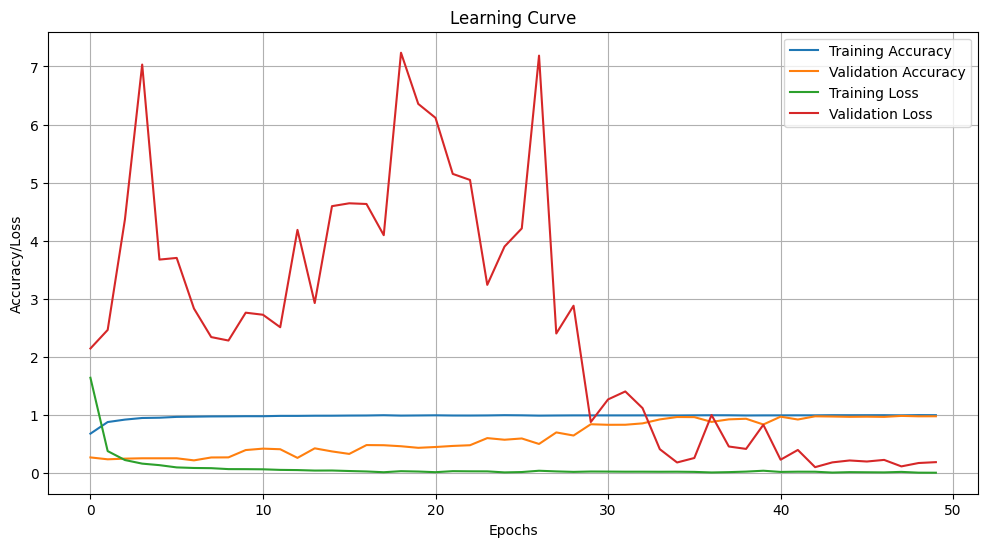


 1/36 [..............................] - ETA: 4s - loss: 7.4795e-06 - accuracy: 1.0000


 2/36 [>.............................] - ETA: 4s - loss: 0.0978 - accuracy: 0.9688    


 3/36 [=>............................] - ETA: 4s - loss: 0.0652 - accuracy: 0.9792


 5/36 [===>..........................] - ETA: 3s - loss: 0.0762 - accuracy: 0.9812


 6/36 [====>.........................] - ETA: 3s - loss: 0.0667 - accuracy: 0.9844


 8/36 [=====>........................] - ETA: 2s - loss: 0.0502 - accuracy: 0.9883


 9/36 [======>.......................] - ETA: 2s - loss: 0.0870 - accuracy: 0.9861


11/36 [========>.....................] - ETA: 2s - loss: 0.0715 - accuracy: 0.9886


12/36 [=========>....................] - ETA: 2s - loss: 0.0691 - accuracy: 0.9870


14/36 [==========>...................] - ETA: 2s - loss: 0.0592 - accuracy: 0.9888


15/36 [===========>..................] - ETA: 2s - loss: 0.0953 - accuracy: 0.9833


17/36 [=============>................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9835


18/36 [==============>...............] - ETA: 1s - loss: 0.0835 - accuracy: 0.9844


20/36 [===============>..............] - ETA: 1s - loss: 0.0793 - accuracy: 0.9844


21/36 [================>.............] - ETA: 1s - loss: 0.0871 - accuracy: 0.9836


23/36 [==================>...........] - ETA: 1s - loss: 0.0832 - accuracy: 0.9823


24/36 [===================>..........] - ETA: 1s - loss: 0.0798 - accuracy: 0.9831


26/36 [====================>.........] - ETA: 0s - loss: 0.1430 - accuracy: 0.9820


27/36 [=====================>........] - ETA: 0s - loss: 0.1467 - accuracy: 0.9815


29/36 [=======================>......] - ETA: 0s - loss: 0.1605 - accuracy: 0.9806


30/36 [========================>.....] - ETA: 0s - loss: 0.1554 - accuracy: 0.9812


32/36 [=========================>....] - ETA: 0s - loss: 0.1847 - accuracy: 0.9795


33/36 [==========================>...] - ETA: 0s - loss: 0.1794 - accuracy: 0.9801


35/36 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9795


36/36 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9781


36/36 [==============================] - 4s 100ms/step - loss: 0.1882 - accuracy: 0.9781


Validation Loss: 0.1882043182849884
Validation Accuracy: 0.9781277179718018


In [ ]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Performance')
plt.legend()
plt.grid(True)

# Validation Graph: Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Validation Performance')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the validation (split) set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 403ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 107ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step


Predicted label: glioma
Predicted label: meningioma
Predicted label: notumor
Predicted label: pituitary



 1/41 [..............................] - ETA: 5s - loss: 1.4896e-05 - accuracy: 1.0000


 2/41 [>.............................] - ETA: 5s - loss: 8.2003e-06 - accuracy: 1.0000


 3/41 [=>............................] - ETA: 4s - loss: 4.9809e-04 - accuracy: 1.0000


 5/41 [==>...........................] - ETA: 3s - loss: 4.7678e-04 - accuracy: 1.0000


 6/41 [===>..........................] - ETA: 3s - loss: 3.9731e-04 - accuracy: 1.0000


 8/41 [====>.........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000    


 9/41 [=====>........................] - ETA: 3s - loss: 0.0568 - accuracy: 0.9931


11/41 [=======>......................] - ETA: 3s - loss: 0.1583 - accuracy: 0.9886


12/41 [=======>......................] - ETA: 3s - loss: 0.1638 - accuracy: 0.9870


14/41 [=========>....................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9844


15/41 [=========>....................] - ETA: 2s - loss: 0.1598 - accuracy: 0.9833


17/41 [===========>..................] - ETA: 2s - loss: 0.1419 - accuracy: 0.9853


18/41 [============>.................] - ETA: 2s - loss: 0.1577 - accuracy: 0.9844


20/41 [=============>................] - ETA: 2s - loss: 0.1566 - accuracy: 0.9828


21/41 [==============>...............] - ETA: 2s - loss: 0.1491 - accuracy: 0.9836


23/41 [===============>..............] - ETA: 1s - loss: 0.1362 - accuracy: 0.9851


24/41 [================>.............] - ETA: 1s - loss: 0.1305 - accuracy: 0.9857


26/41 [==================>...........] - ETA: 1s - loss: 0.1205 - accuracy: 0.9868


27/41 [==================>...........] - ETA: 1s - loss: 0.1160 - accuracy: 0.9873


29/41 [====================>.........] - ETA: 1s - loss: 0.1080 - accuracy: 0.9881


30/41 [====================>.........] - ETA: 1s - loss: 0.1044 - accuracy: 0.9885


32/41 [======================>.......] - ETA: 0s - loss: 0.0981 - accuracy: 0.9893


33/41 [=======================>......] - ETA: 0s - loss: 0.1040 - accuracy: 0.9886


35/41 [========================>.....] - ETA: 0s - loss: 0.0981 - accuracy: 0.9893


36/41 [=========================>....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9896


38/41 [==========================>...] - ETA: 0s - loss: 0.0903 - accuracy: 0.9901


39/41 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9904


41/41 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9908


41/41 [==============================] - 4s 102ms/step - loss: 0.0839 - accuracy: 0.9908


Testing Loss: 0.08388587087392807
Testing Accuracy: 0.9908466935157776


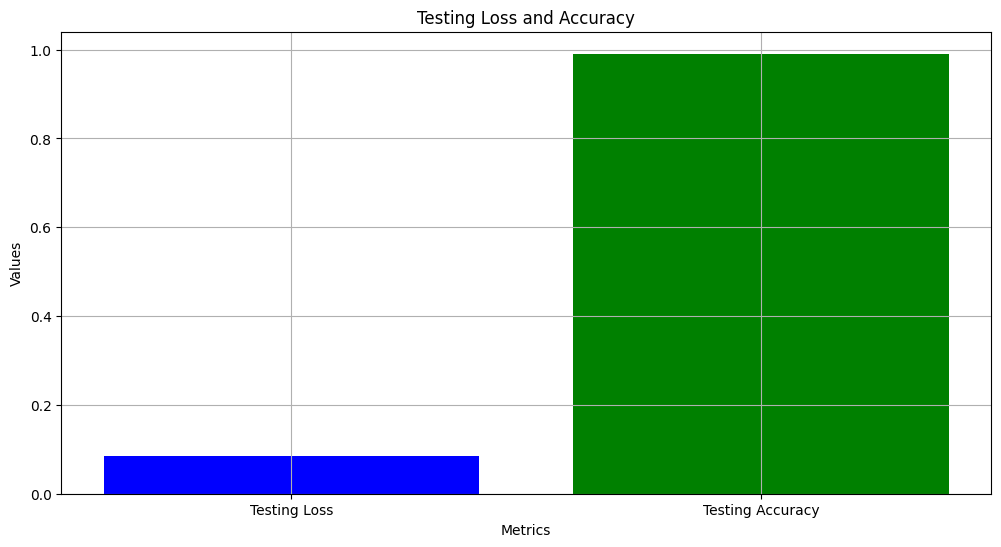

In [ ]:
def test_image(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)  # Get the class index with the highest probability

    # Return the predicted label
    predicted_label = class_labels_reverse[predicted_class[0]]  # Map the class index to label
    return predicted_label

test_image_path1 = os.path.join(os.environ['DATASET_PATH'], 'Testing/glioma/Te-gl_0010.jpg')
test_image_path2 = os.path.join(os.environ['DATASET_PATH'], 'Testing/meningioma/Te-me_0018.jpg')
test_image_path3 = os.path.join(os.environ['DATASET_PATH'], 'Testing/notumor/Te-no_0027.jpg')
test_image_path4 = os.path.join(os.environ['DATASET_PATH'], 'Testing/pituitary/Te-pi_0094.jpg')

predicted_label1 = test_image(model, test_image_path1)
predicted_label2 = test_image(model, test_image_path2)
predicted_label3 = test_image(model, test_image_path3)
predicted_label4 = test_image(model, test_image_path4)

print(f"Predicted label: {predicted_label1}")
print(f"Predicted label: {predicted_label2}")
print(f"Predicted label: {predicted_label3}")
print(f"Predicted label: {predicted_label4}")

# Load the testing dataset
testing_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Testing')

test_images = []
test_labels = []

# Loop over the folders in the Testing dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(testing_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 or any size you prefer

        # Append image and label (use list append method)
        test_images.append(img)
        test_labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize the test images
test_images = test_images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
test_X_rgb = np.repeat(test_images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_X_rgb, test_labels)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_acc}")

# Plot the testing loss and accuracy (Should use Confusion Matrix for better evaluation)
plt.figure(figsize=(12, 6))
plt.bar(['Testing Loss', 'Testing Accuracy'], [test_loss, test_acc], color=['blue', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Testing Loss and Accuracy')
plt.grid(True)
plt.show()